In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import terphenyl_simulations as hs
import MDAnalysis as mda
import mdtraj as md
import numpy as np
import scipy as sp
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

# Constructing a helix configuration for the MOP-terphenyl octamer system
In this notebook I will be using structural information from a MOP-terphenyl hexamer simulation to construct an octamer in an identified helix configuration. I'm moving this from a simple python script to a jupyter notebook to ease the development of this task.

Originally we constructed MOP-terphenyl helices by only using the a1, a2, p1, p2 and p3 torsion of the MOP-terphenyl system of an energy minimized structure. While we believed these to be the only flexible torsions in the system, setting these torsions from the helix identified in the hexamer system never quite matched the helical configuration very well. So in this notebook we will expand the construction to include all torsions present in a MOP-terphenyl monomer. Including other torsions such as the aromatic torsions should be able to capture slight bending of the aromatic groups that might be accurately captured from the original energy minimzed structure. 

In [3]:
# Get all torsions present in MOP hexamer simulation
hexamer_helix_cluster = mda.Universe("mom_tetramer_mbuild_off-2.0.0.itp", "cluster_0.xtc")

In [4]:
octamer_structure = mda.Universe("mom_octamer_mbuild_off-2.0.0.itp", "mom_octamer_mbuild_off-2.0.0.gro")

## Torsion distributions for helical residues

Using the torsions defined from the first residue we extract out all identical torsions from the identified helical residues from the clustered structure.

In [5]:
# AtomGroup for residue 1
res1_oct = octamer_structure.select_atoms("resid 2")
res1_hex = hexamer_helix_cluster.select_atoms("resid 2")

In [6]:
# Now we can extract the list of all torsions defined in the octamer residue
octamer_r1_dihes = []
for i, d_oct in enumerate(res1_oct.dihedrals):
    dihe_oct = []
    if any([atom.resname != "OCT" for atom in d_oct.atoms]):
        continue
    for atom in d_oct.atoms:
        dihe_oct.append(atom.name)
    octamer_r1_dihes.append(dihe_oct)

In [7]:
octamer_structure.select_atoms("resid 1")

<AtomGroup with 44 atoms>

In [8]:
hexamer_r1_dihes = []
for i, d_hex in enumerate(res1_hex.dihedrals):
    dihe_hex = []
    if any([atom.resname != "TET" for atom in d_hex.atoms]):
        continue
    for atom in d_hex.atoms:
        dihe_hex.append(atom.name)
    hexamer_r1_dihes.append(dihe_hex)

In [9]:
# Using a function in heteropolymer_simulations we can extract the torsions from the entire residue
all_octamer_torsions = []
for torsion_id in octamer_r1_dihes:
    t_ids = hs.utils.get_torsion_ids(octamer_structure, "OCT", torsion_id)
    all_octamer_torsions.append(t_ids)

In [10]:
all_hexamer_torsions = []
for torsion_id in hexamer_r1_dihes:
    t_ids = hs.utils.get_torsion_ids(hexamer_helix_cluster, "TET", torsion_id, template_residue_i=1)
    all_hexamer_torsions.append(t_ids)

In [11]:
# List of all torsion ids within dihedral object
all_torsion_ids = [[d.atoms[0].name, d.atoms[1].name, d.atoms[2].name, d.atoms[3].name,] for d in hexamer_helix_cluster.dihedrals]
len(all_torsion_ids)

493

 24%|██████████▏                               | 30/123 [01:16<03:57,  2.55s/it]/tmp/ipykernel_24153/3270979440.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|█████████████████████████████████████████| 123/123 [04:59<00:00,  2.44s/it]


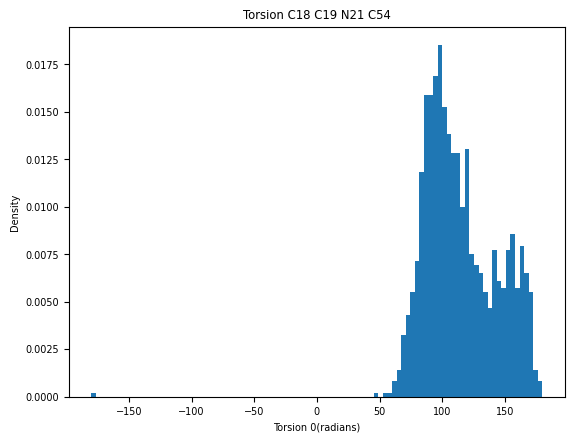

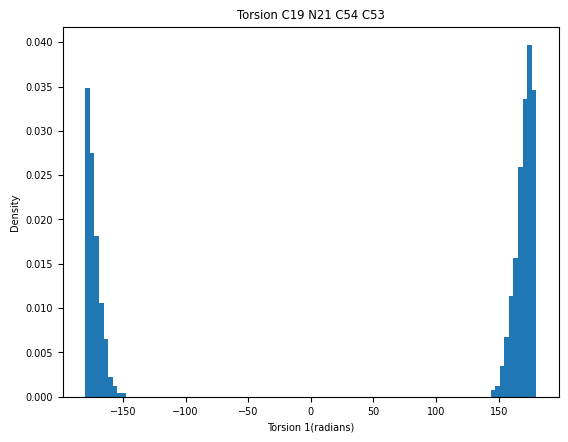

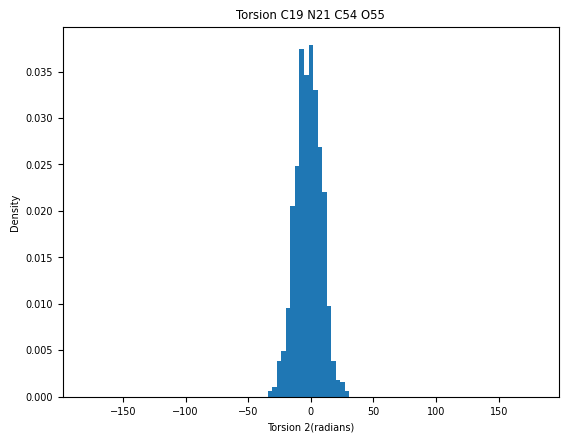

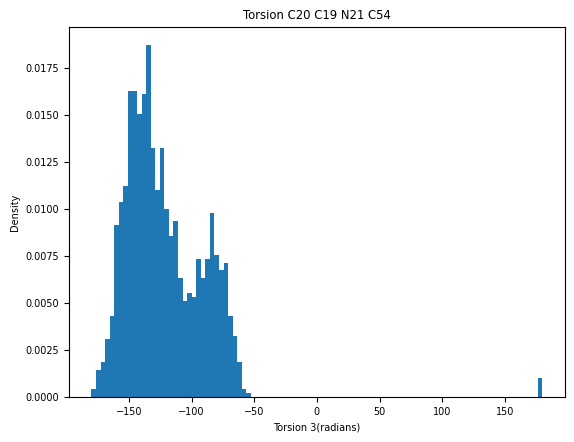

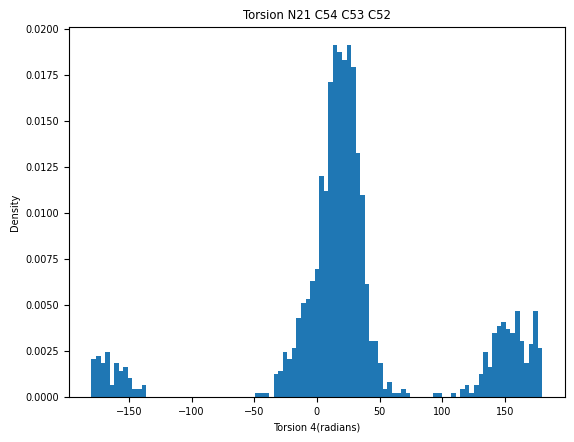

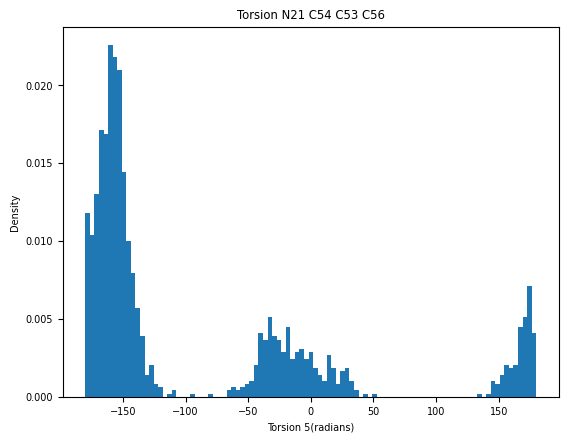

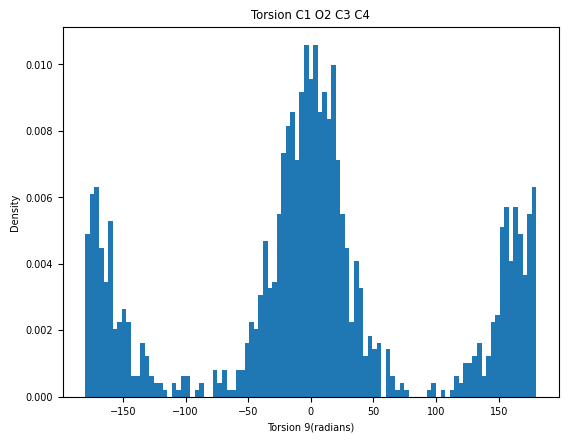

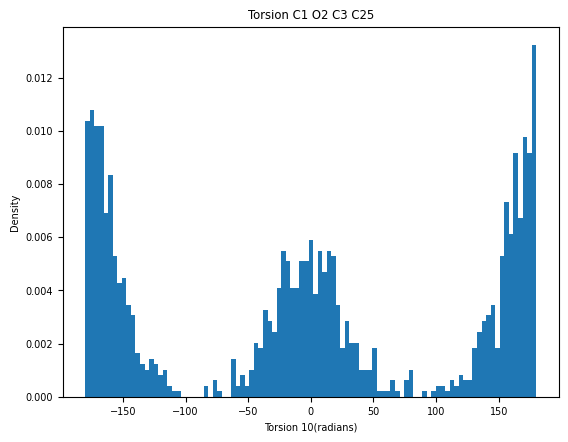

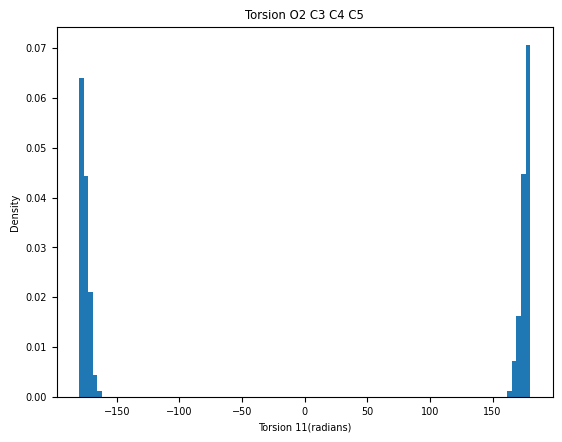

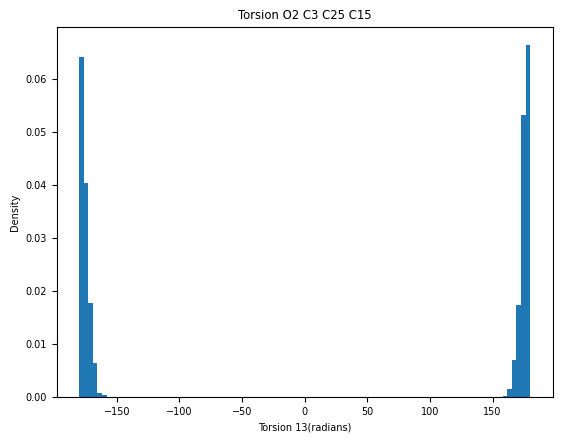

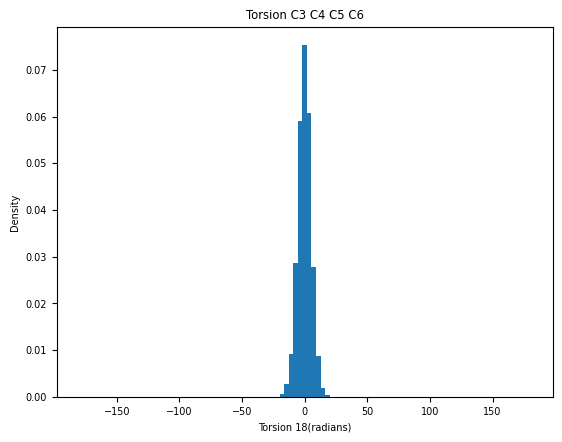

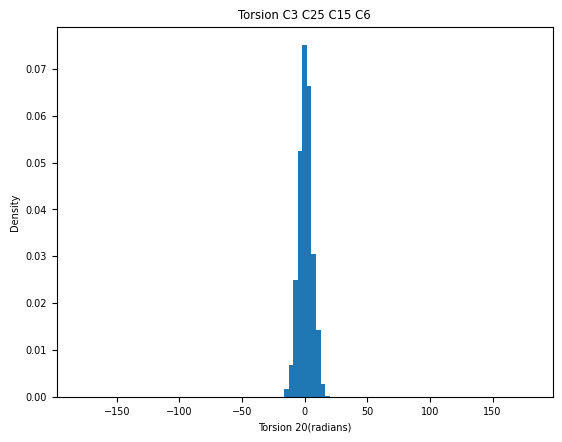

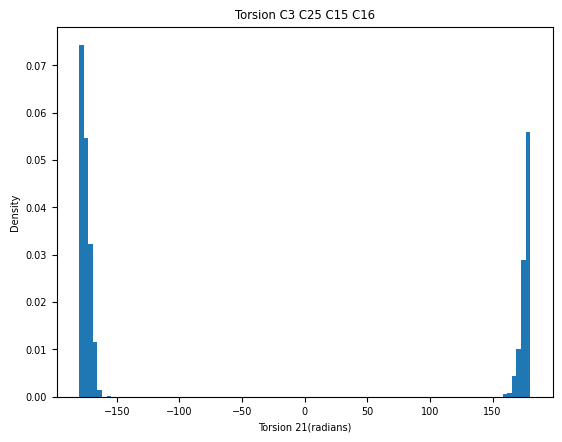

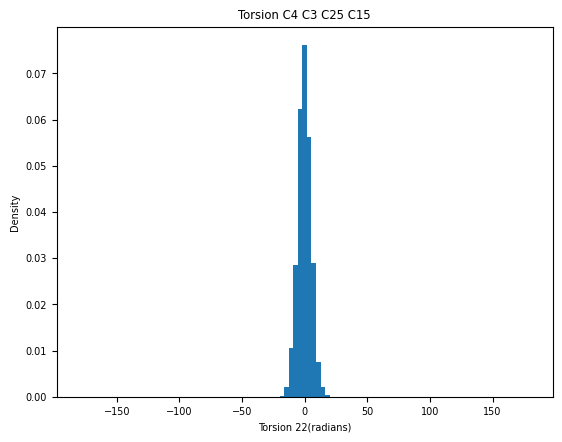

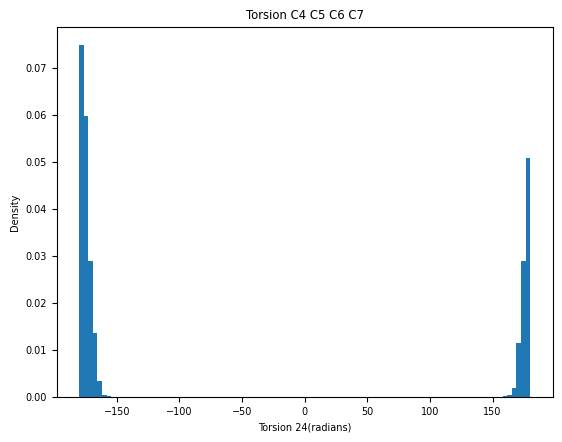

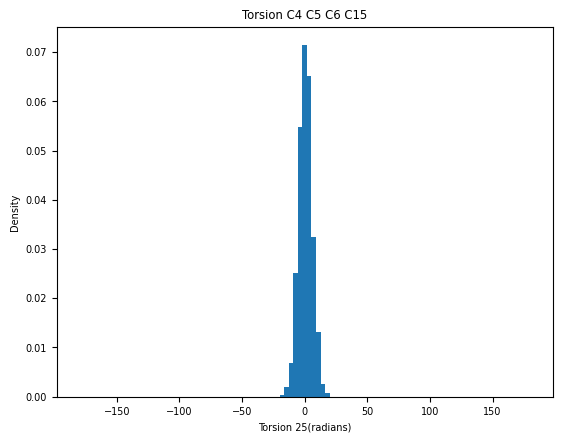

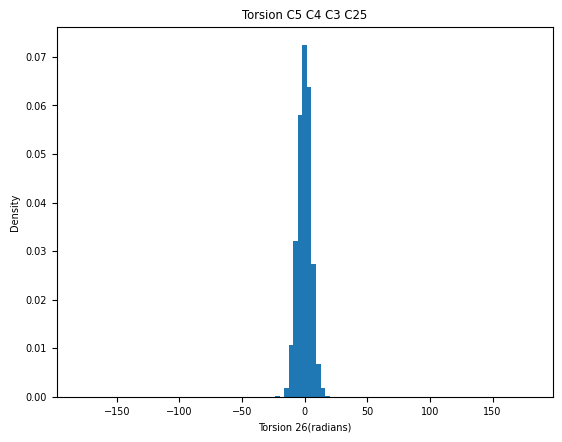

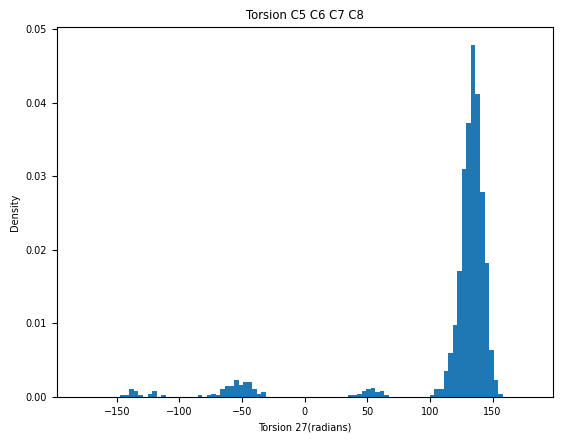

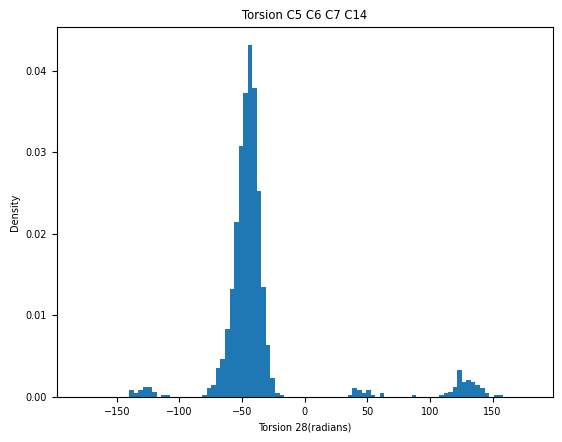

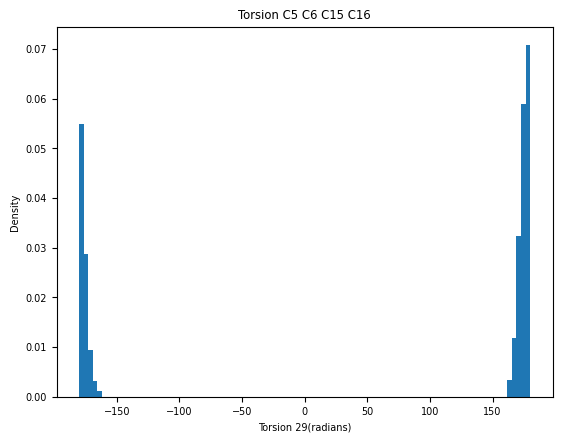

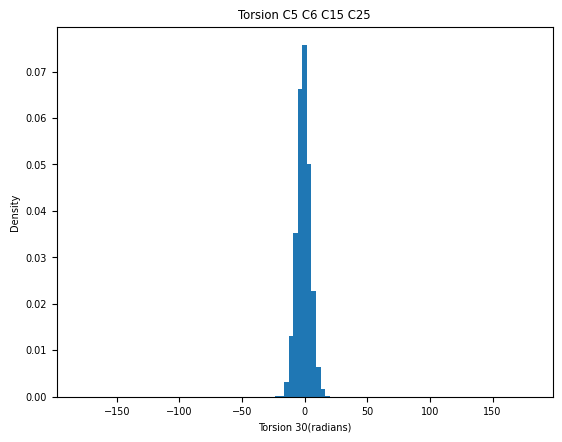

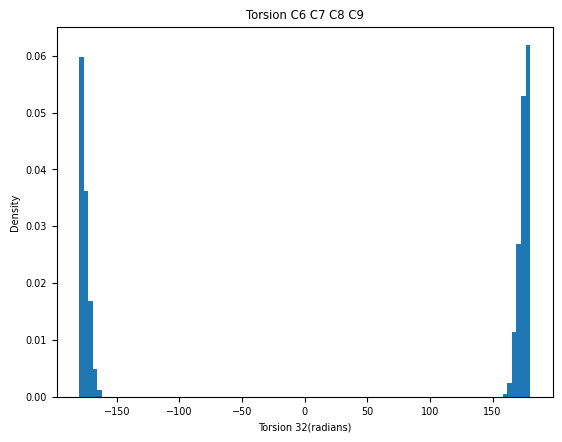

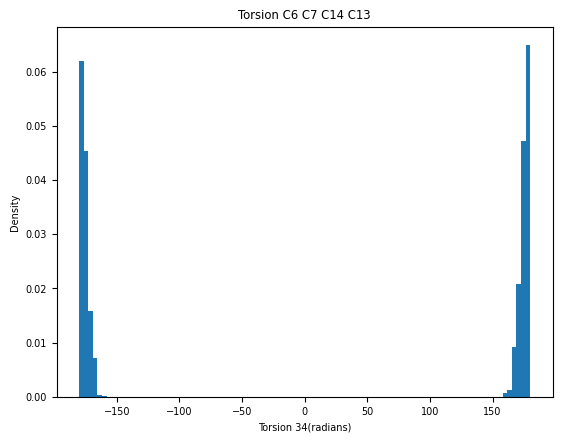

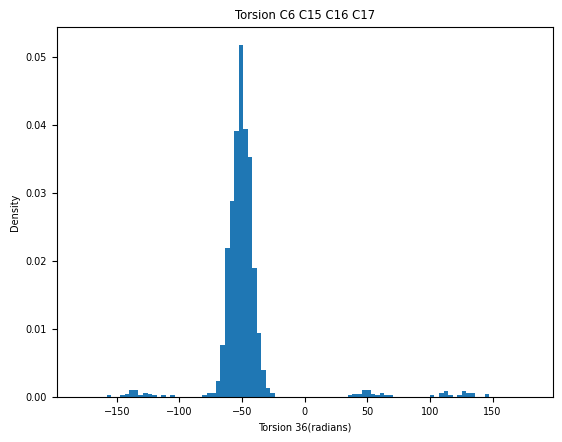

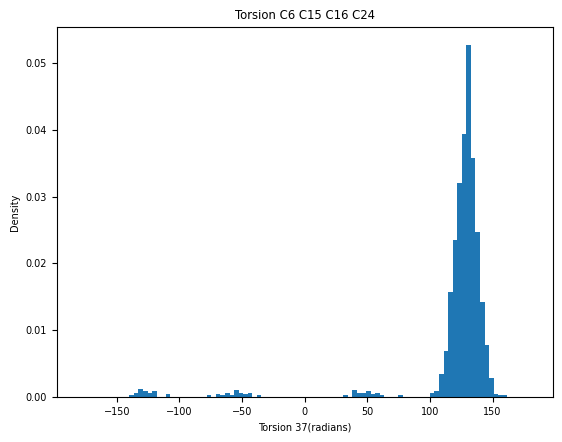

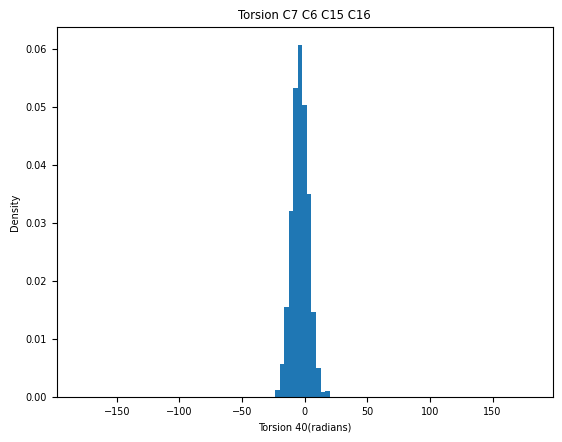

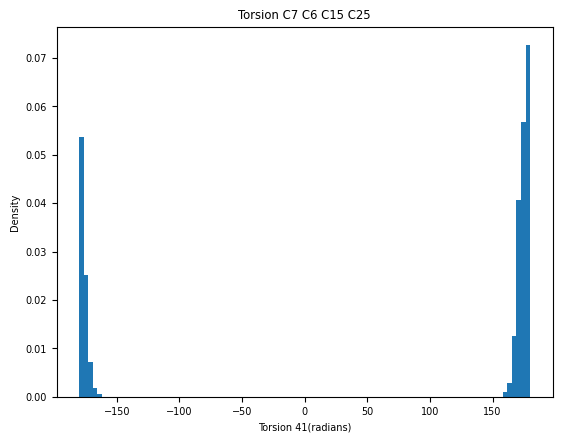

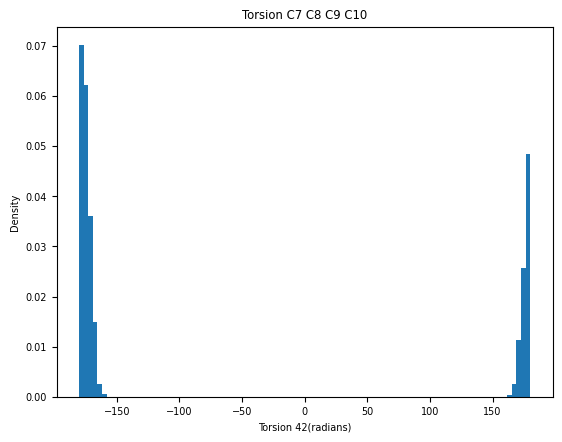

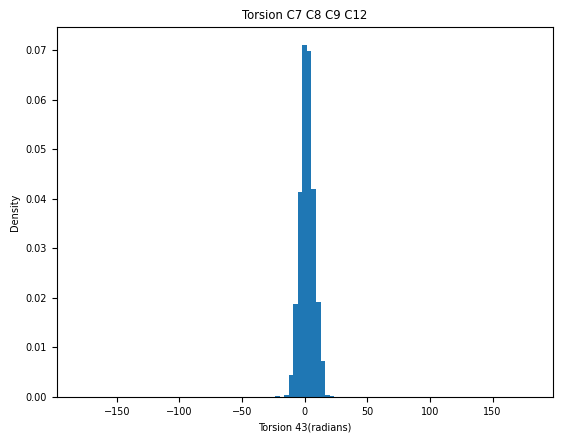

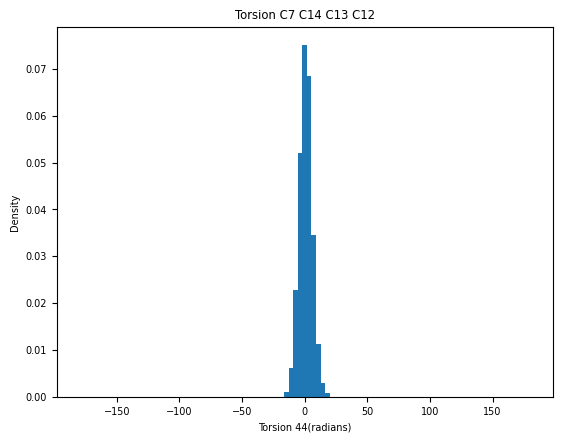

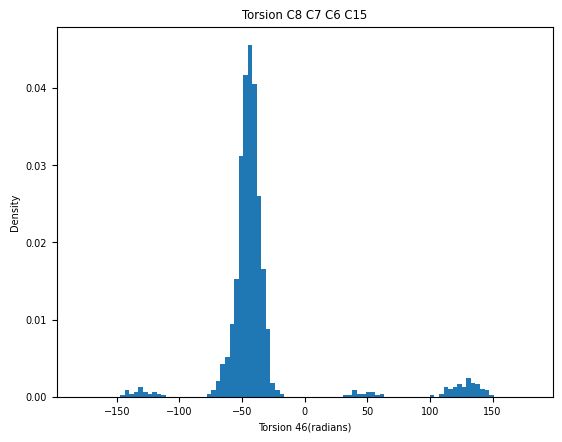

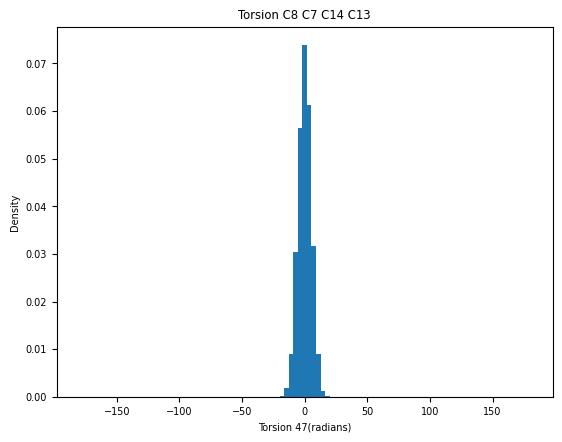

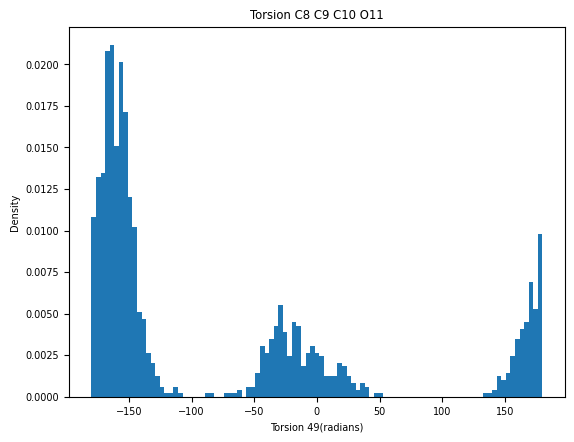

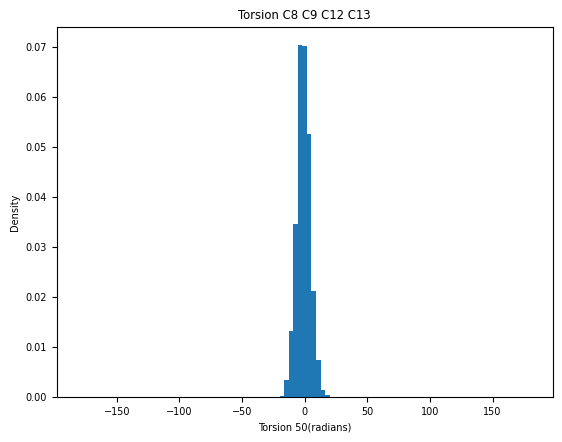

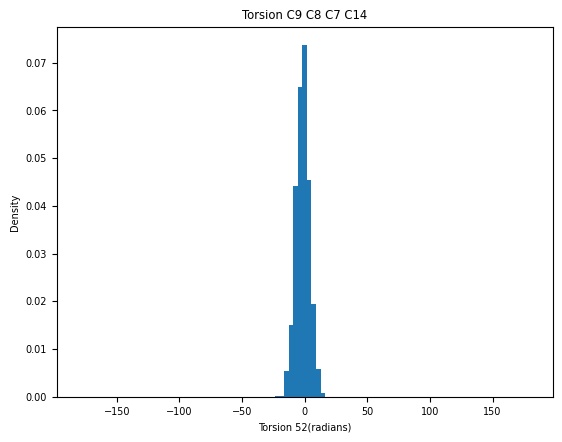

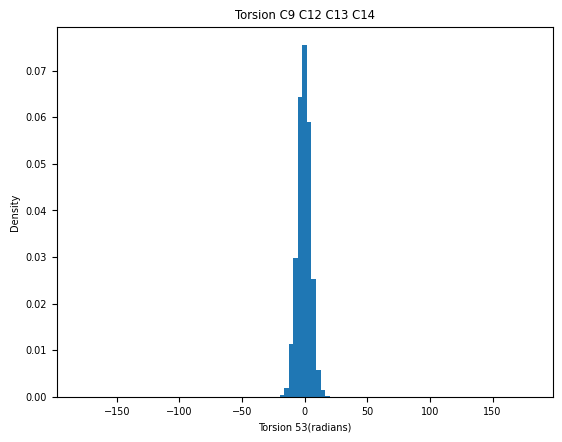

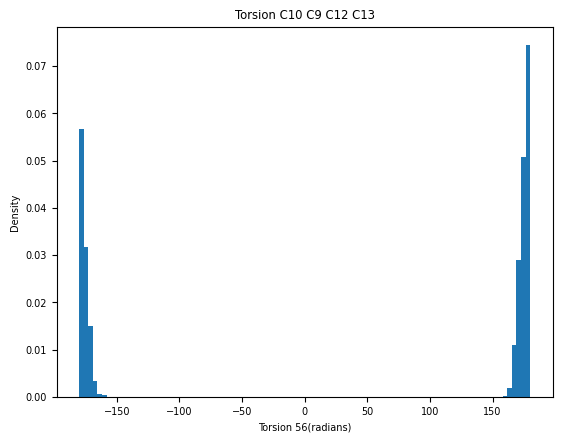

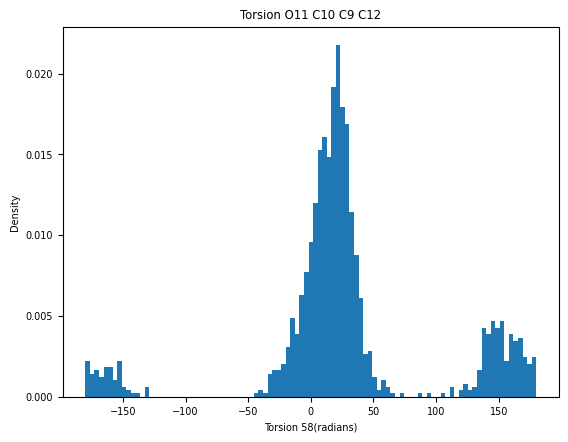

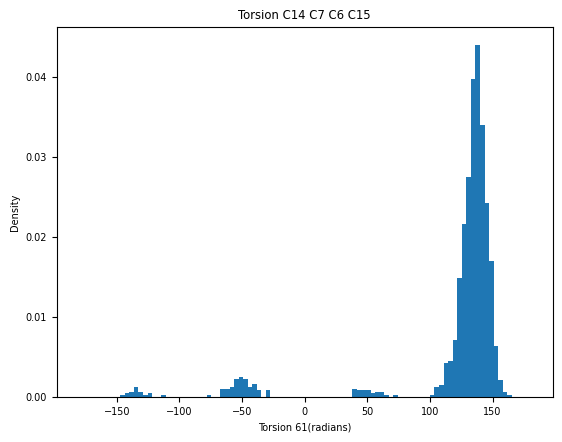

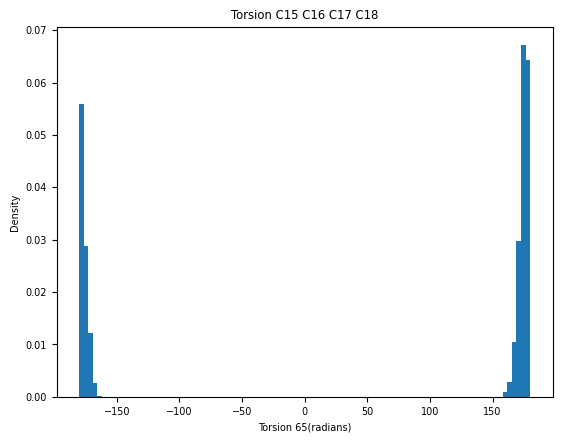

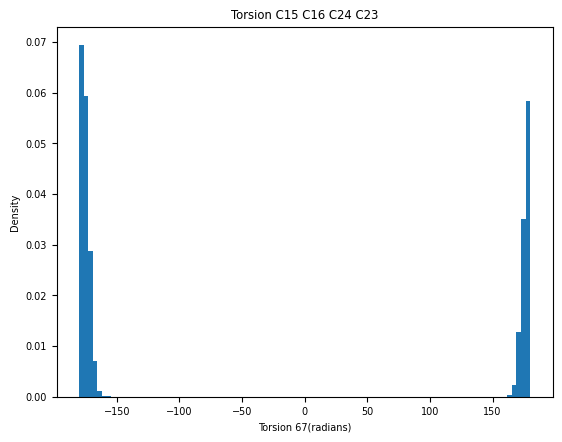

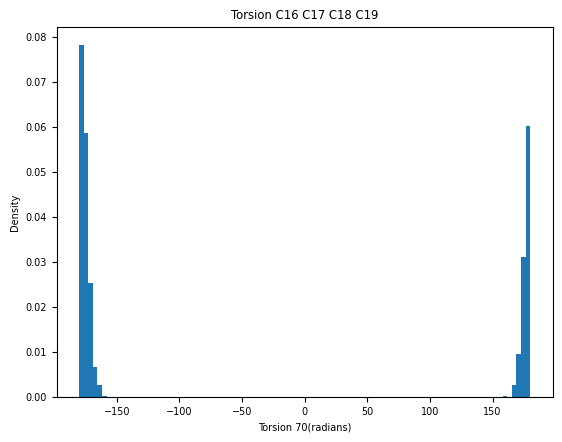

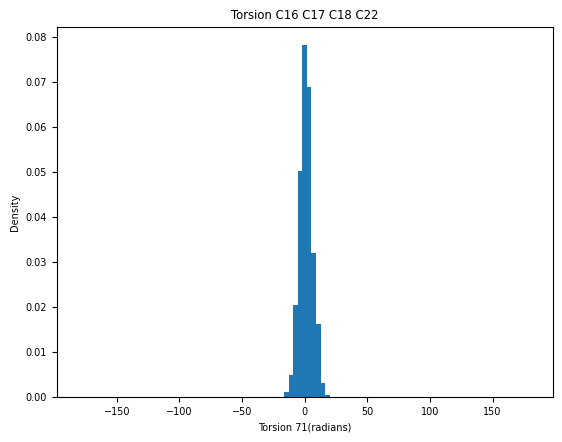

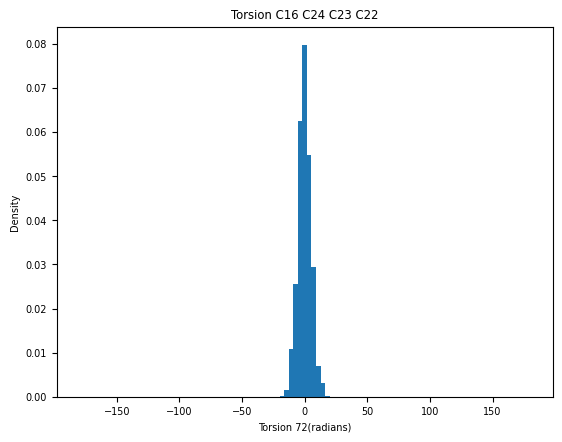

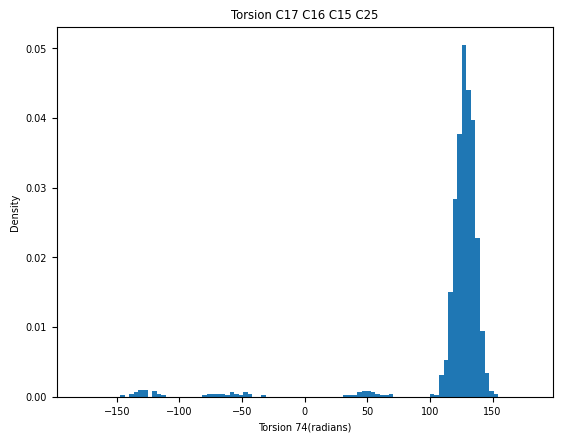

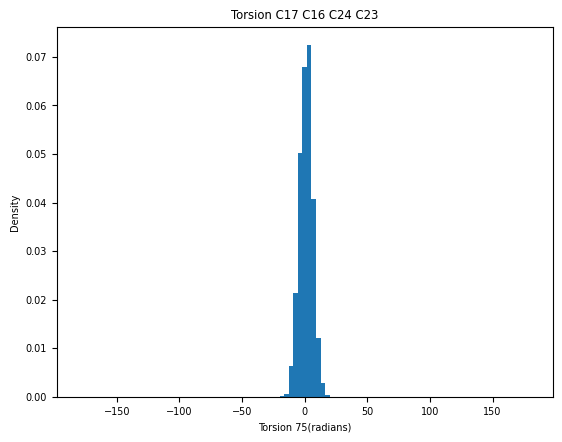

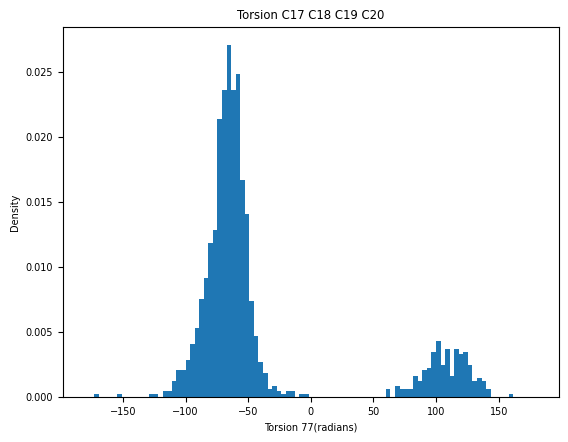

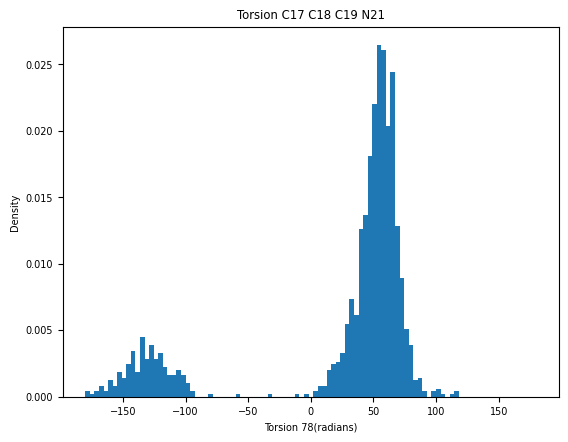

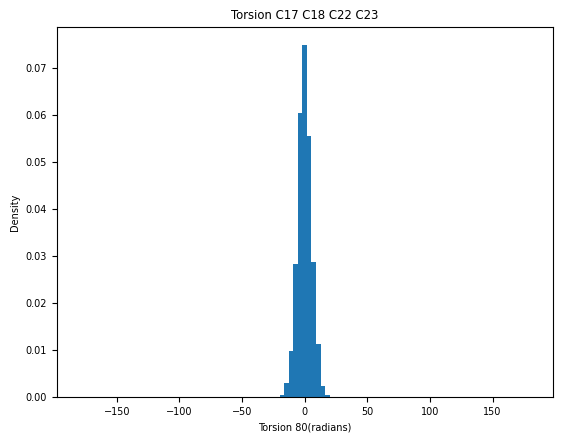

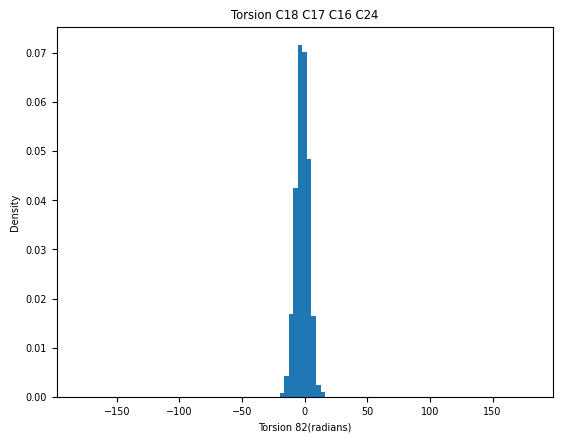

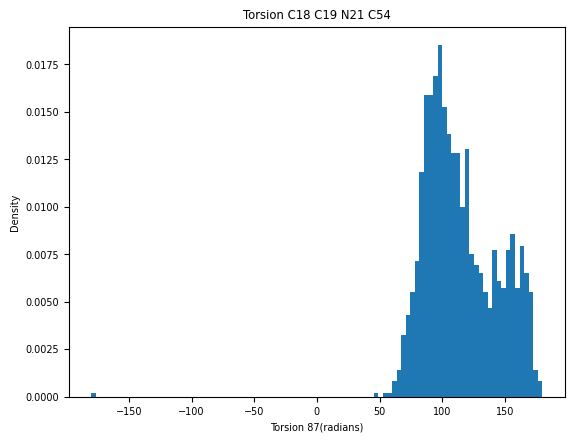

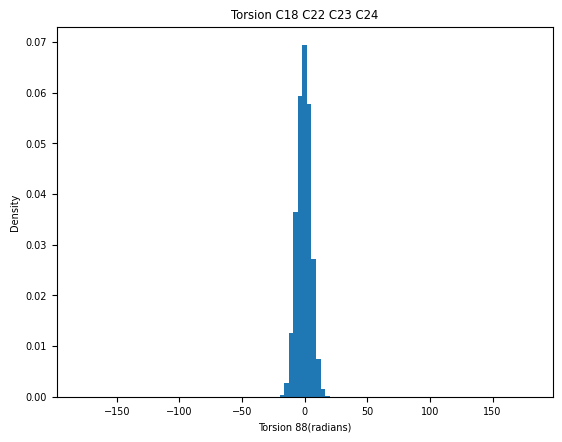

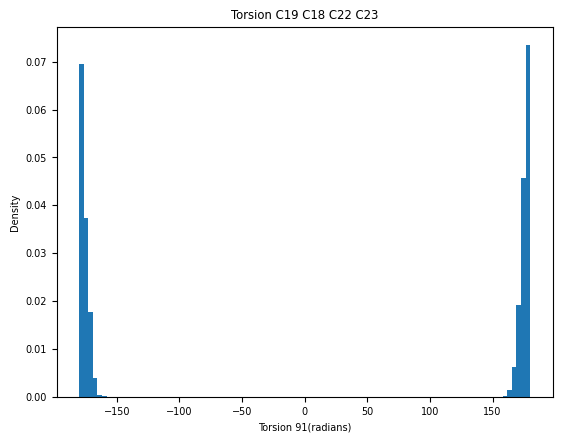

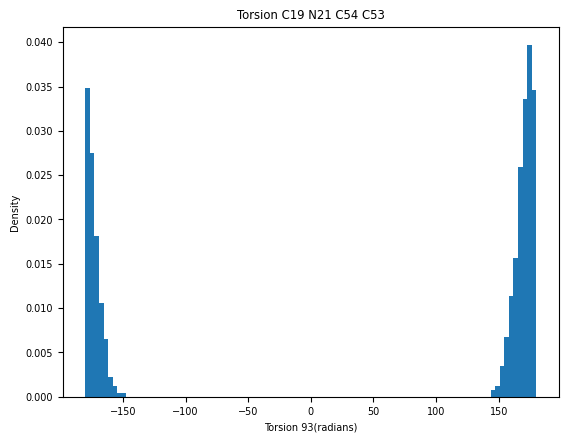

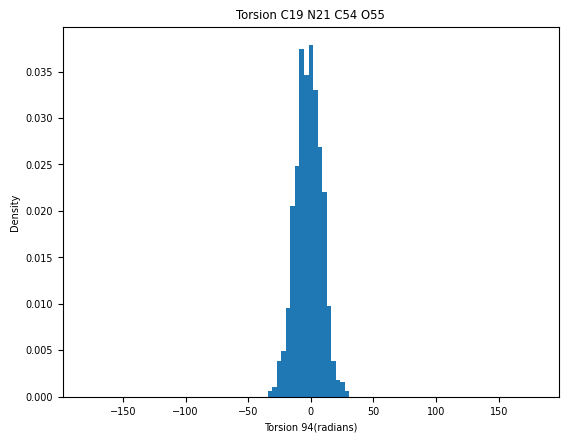

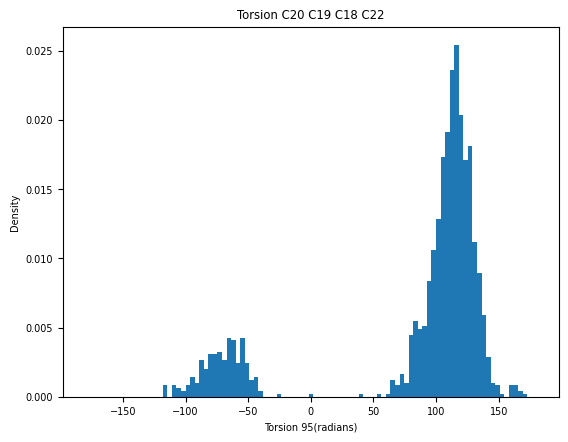

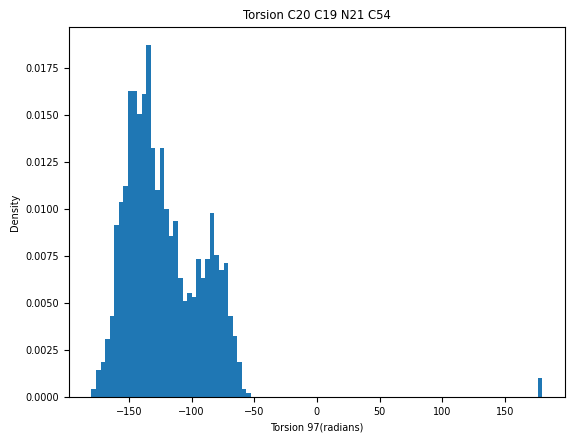

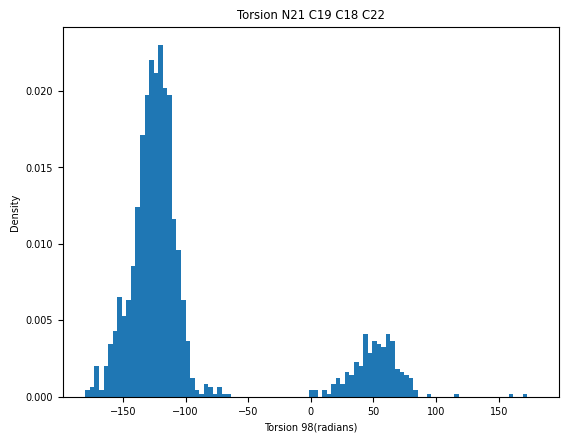

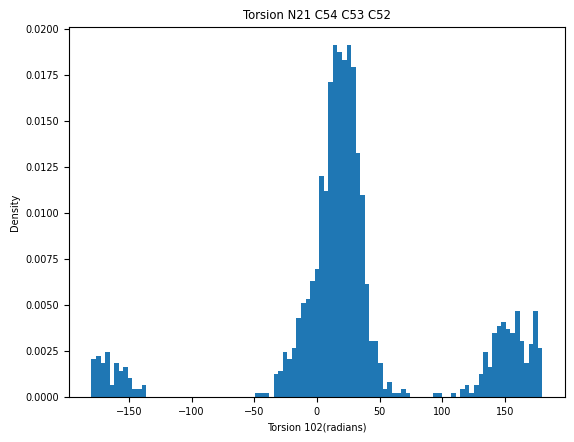

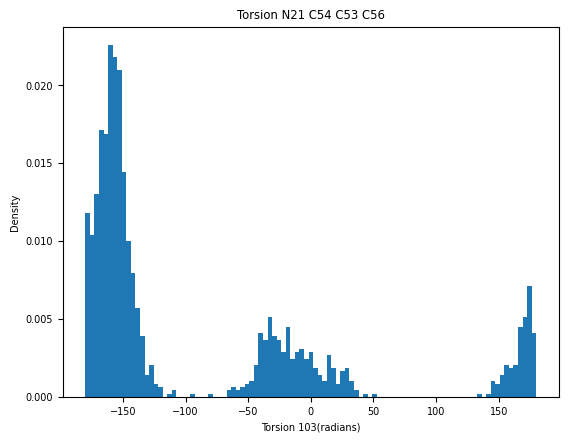

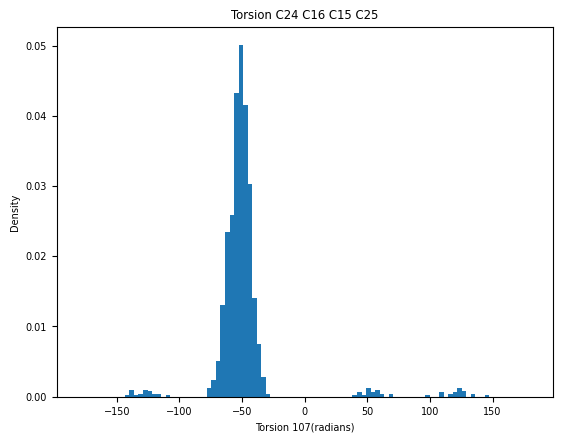

In [12]:
# Now we extract all torsions of the helical segment in the hexamer

plot_distributions = True

ideal_torsions = []
for i in tqdm(range(len(all_hexamer_torsions))):
    torsion_values = []
    # Pull torsions from residues 4,5,6 for all frames
    for ts in hexamer_helix_cluster.trajectory:
        hexamer_helix_cluster.atoms.positions = ts.positions
        for torsion_id in all_hexamer_torsions[i][-3:]:
            torsion_index = all_torsion_ids.index(torsion_id)
            torsion_values.append(hexamer_helix_cluster.dihedrals[torsion_index].value())
    # Plot histogram
    bin_edges = np.linspace(-180, 180, 100)
    if "H" not in " ".join(all_hexamer_torsions[i][0]) and plot_distributions:
        plt.figure()
        plt.hist(torsion_values, bins = bin_edges, density = True)
        plt.title("Torsion " + " ".join(all_hexamer_torsions[i][0]))
        plt.xlabel("Torsion " + str(i) + "(radians)")
        plt.ylabel("Density")
    
    # Save histogram max value
    hist, bin_edges_out = np.histogram(torsion_values, bins = bin_edges, density = True)
    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges) - 1)]
    torsion_max_density = bin_centers[np.argmax(hist)]
    ideal_torsions.append(torsion_max_density)
    
ideal_torsions = np.array(ideal_torsions)

### Residue Correlation for Torsions
We notice that some of the torsions identified are bimodal. In particular, we'll look at the `C17 C19 N1 C23` torsion on a per-residue basis to see if are any correlations between residues. We take a look at 2D histograms for this torsions below. Residue 4, 5 and 6 are helical in `cluster_23.gro`. 

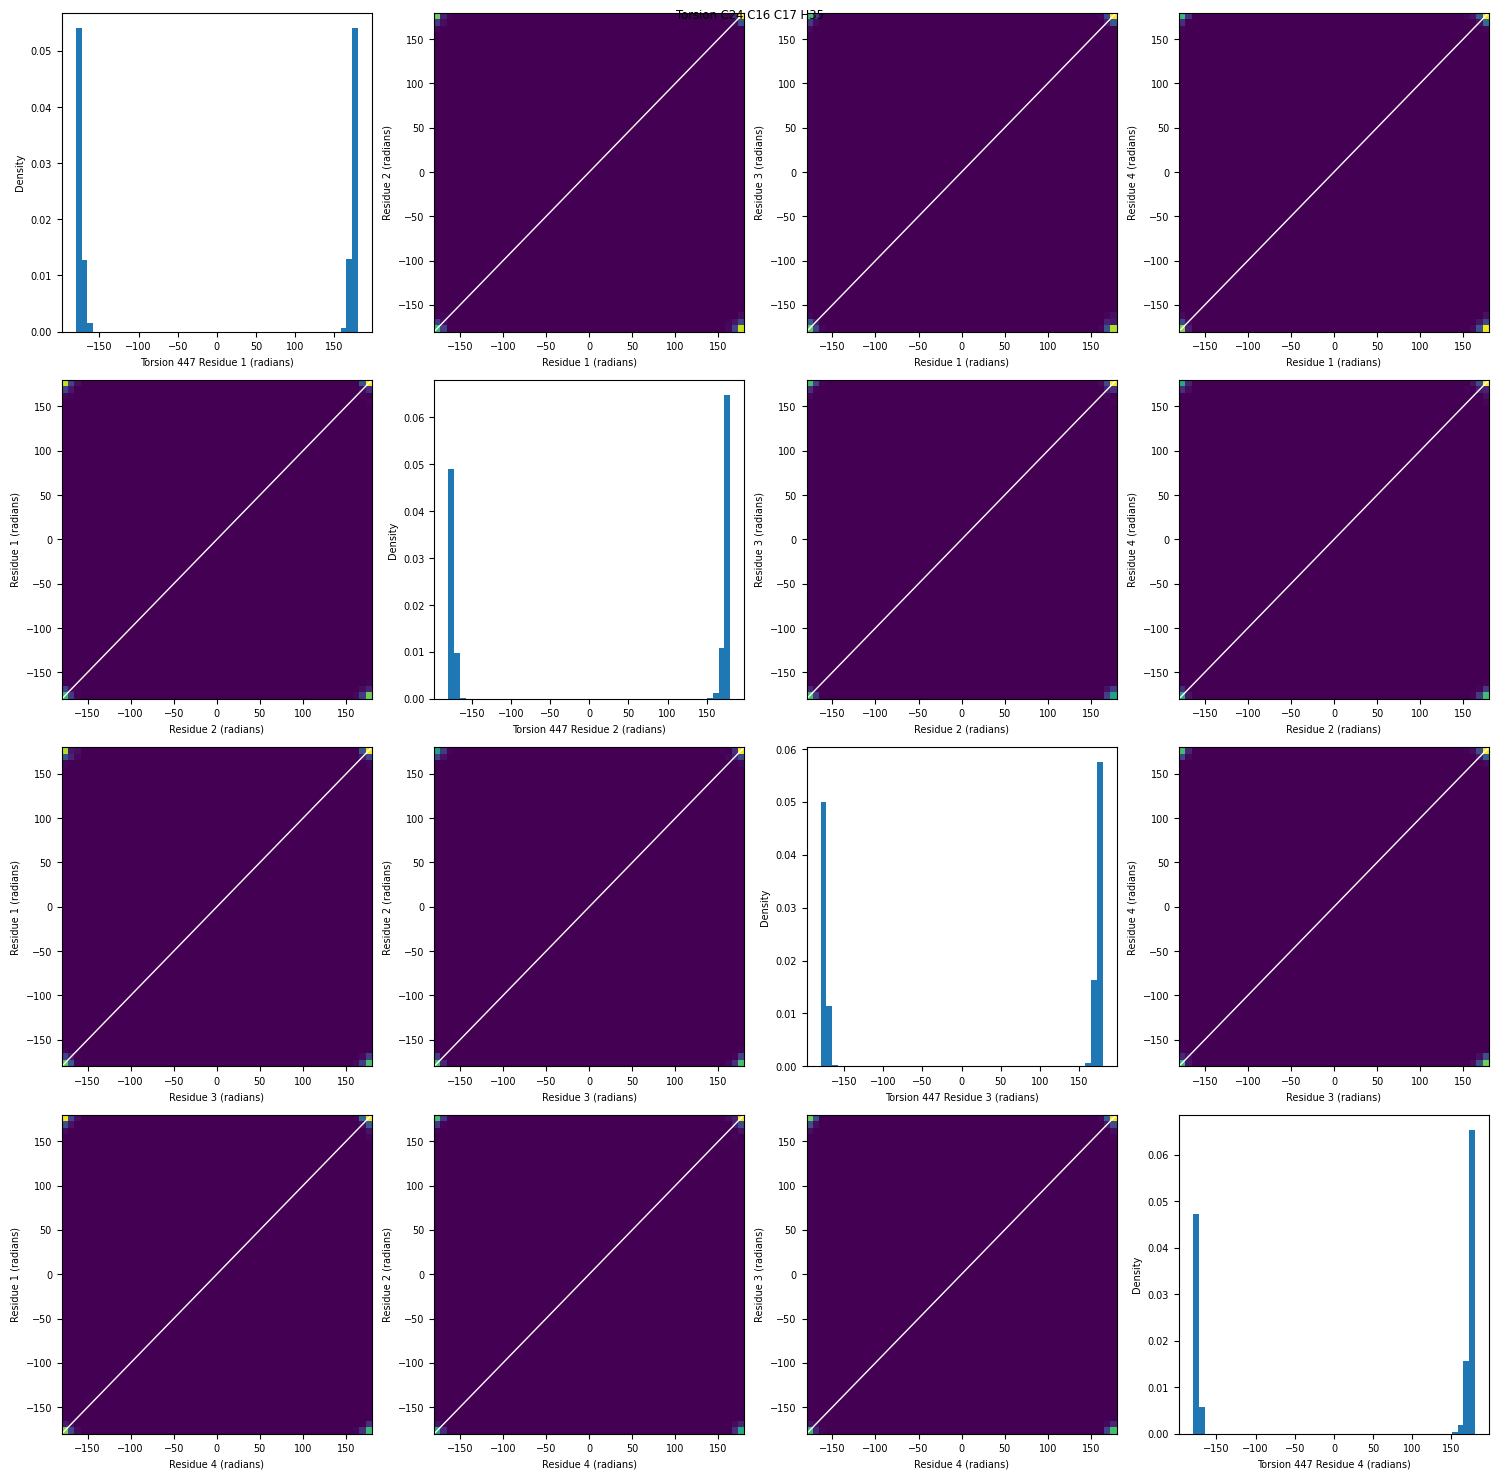

In [13]:
# Per residue distribution for first torsion
torsion_select = 108

all_residue_torsions = []
for torsion_id in all_hexamer_torsions[torsion_select]:
    per_residue_torsions = []
    for ts in hexamer_helix_cluster.trajectory:
        hexamer_helix_cluster.atoms.positions = ts.positions
        torsion_index = all_torsion_ids.index(torsion_id)
        per_residue_torsions.append(hexamer_helix_cluster.dihedrals[torsion_index].value())
    all_residue_torsions.append(per_residue_torsions)

bin_edges = np.linspace(-180, 180, 50)
fig, ax = plt.subplots(nrows = len(all_residue_torsions), ncols = len(all_residue_torsions), figsize = [15,15])
for i in range(len(all_residue_torsions)):
    for j in range(len(all_residue_torsions)):
        if i == j:
            # 1D histogram
            ax[i,j].hist(all_residue_torsions[i], bins = bin_edges, density = True)
            ax[i,j].set_xlabel("Torsion " + str(torsion_index) + " Residue " + str(i + 1) + " (radians)")
            ax[i,j].set_ylabel("Density")
        if i != j:
            # 2D histogram
            ax[i,j].hist2d(all_residue_torsions[j], all_residue_torsions[i], density = True, bins = bin_edges)
            ax[i,j].plot(bin_edges, bin_edges, color = "w", linewidth=1)
            ax[i,j].set_xlabel("Residue " + str(i+1)+ " (radians)")
            ax[i,j].set_ylabel("Residue " + str(j+1)+ " (radians)")
fig.suptitle("Torsion " + " ".join(all_hexamer_torsions[torsion_select][0]))
plt.tight_layout()

# Bond-angle distributions for helical residues

Now we repeat the same proceedure above, but with bond-angles defined in residue 1. Generating all bond-angle distributions will be used to set bond-angles in the final adjusted helix structure.

In [20]:
hexamer_r1_angles = []
for i, angle in enumerate(res1_hex.angles):
    angle_atoms = []
    for atom in angle.atoms:
        angle_atoms.append(atom.name)
    hexamer_r1_angles.append(angle_atoms)

In [21]:
hexamer_angles = []
for r1_angle_id in hexamer_r1_angles:
    angle_ids = hs.utils.get_angle_ids(hexamer_helix_cluster, "TET", r1_angle_id, template_residue_i=1)
    hexamer_angles.append(angle_ids)

In [22]:
octamer_angles = []
for r1_angle_id in hexamer_r1_angles:
    angle_ids = hs.utils.get_angle_ids(octamer_structure, "OCT", r1_angle_id, template_residue_i = 1)
    octamer_angles = [angle_ids]

In [23]:
all_angle_ids = [[a.atoms[0].name, a.atoms[1].name, a.atoms[2].name] for a in hexamer_helix_cluster.angles]

 24%|██████████▎                                | 20/83 [00:38<02:23,  2.27s/it]/tmp/ipykernel_24153/1349329570.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|███████████████████████████████████████████| 83/83 [02:43<00:00,  1.97s/it]


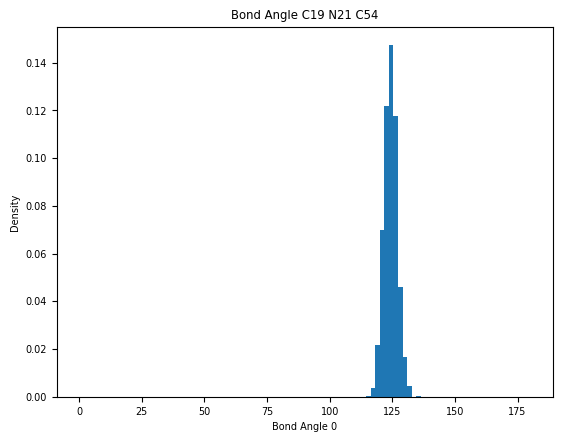

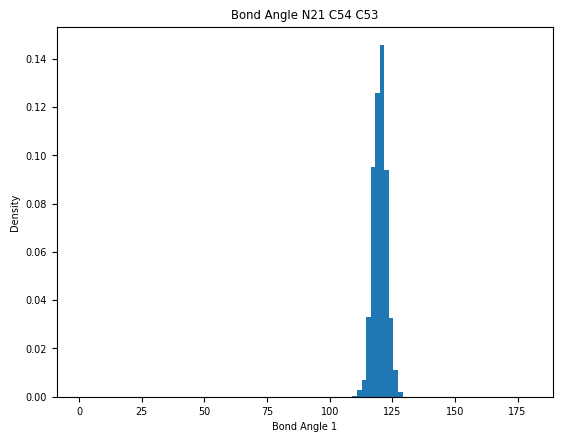

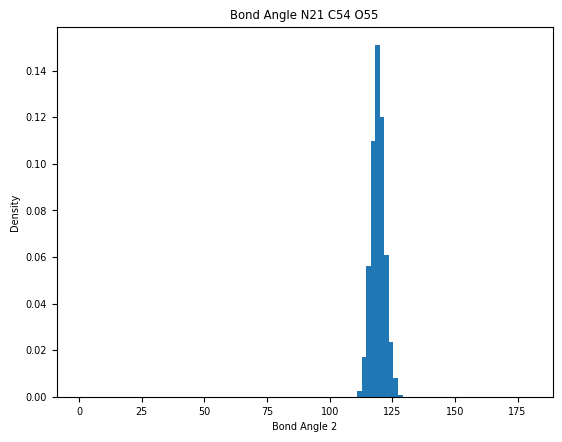

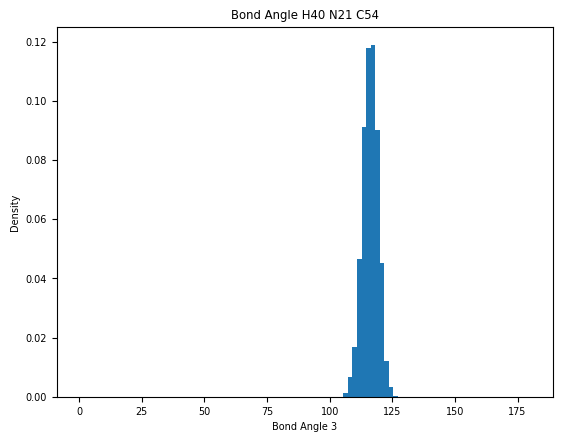

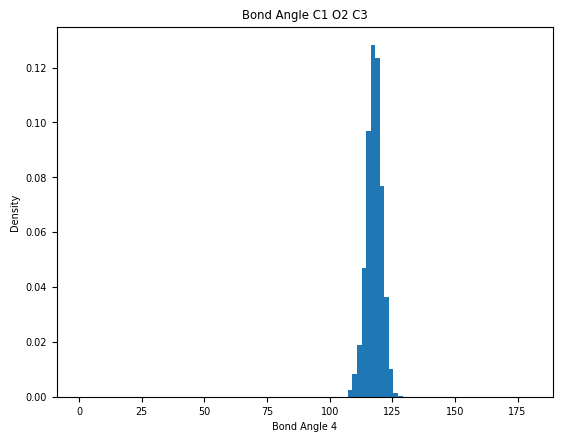

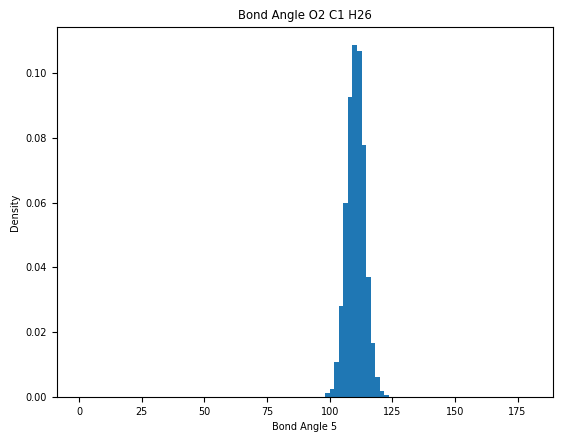

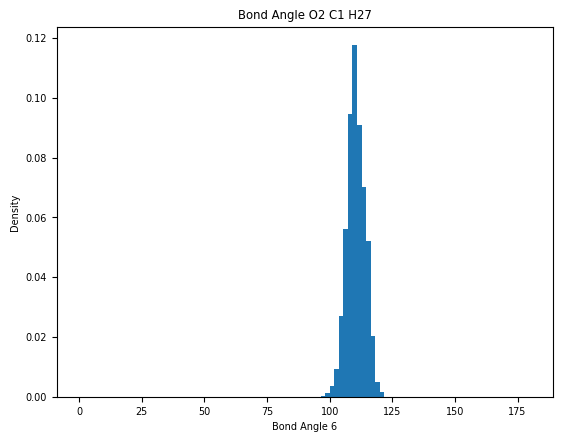

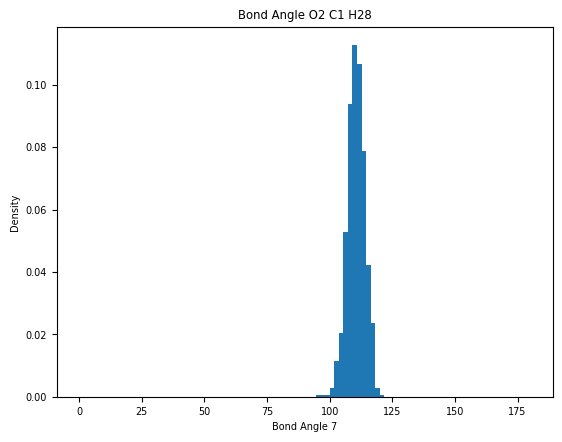

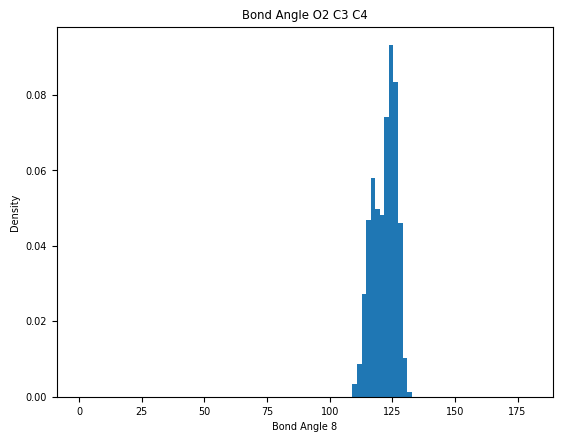

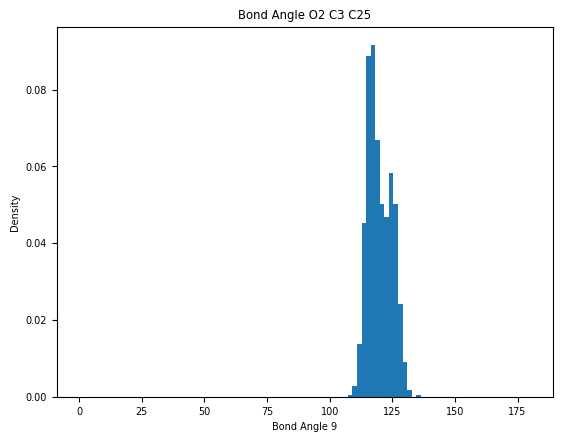

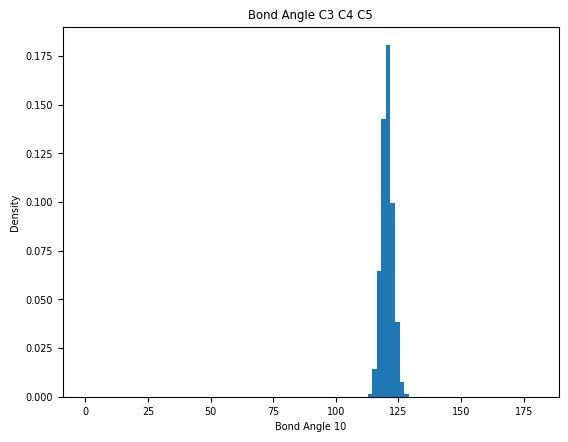

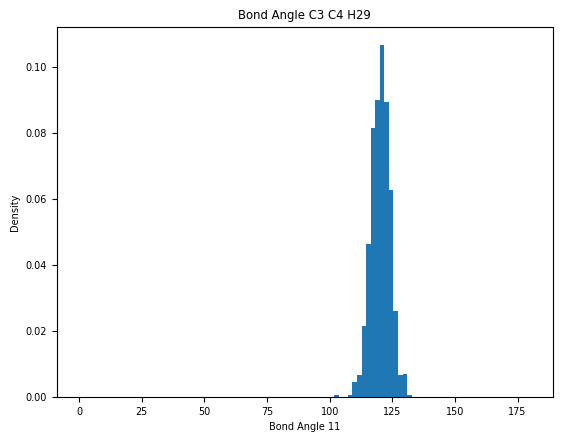

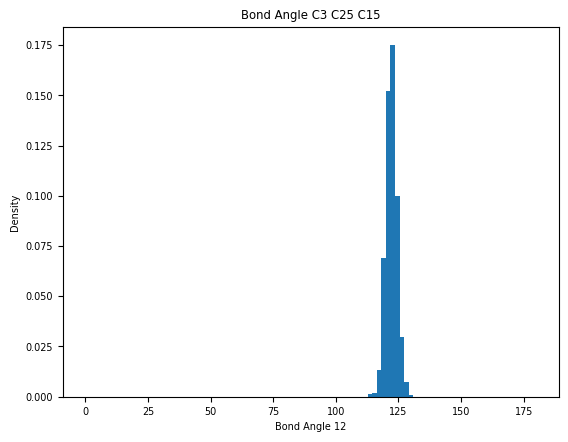

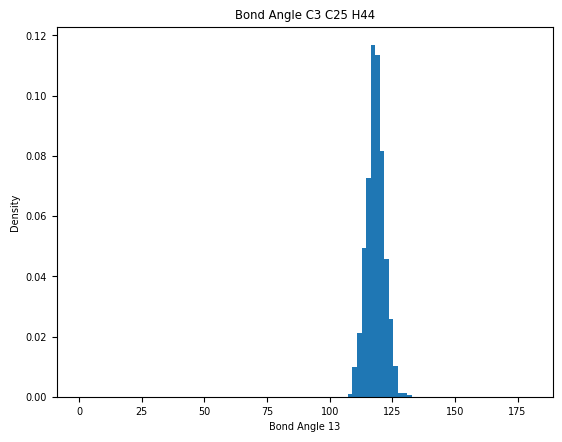

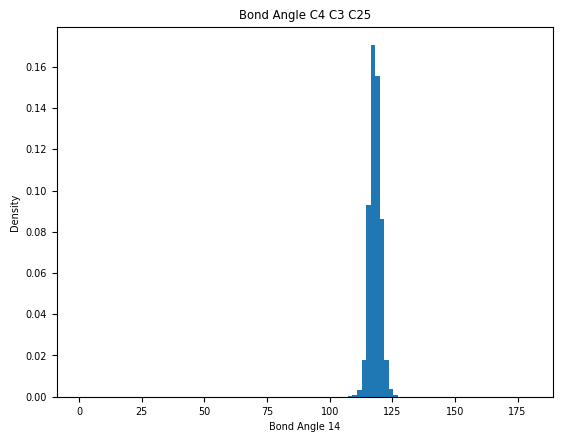

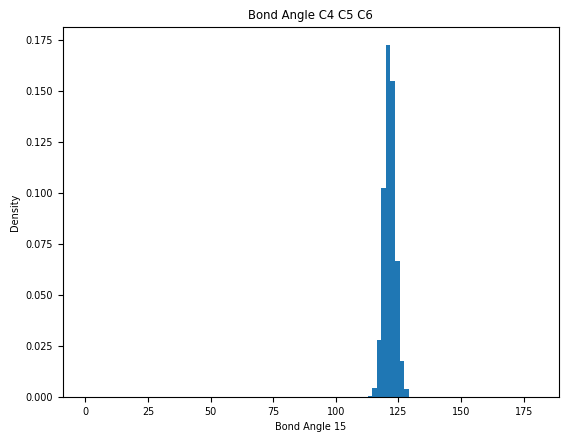

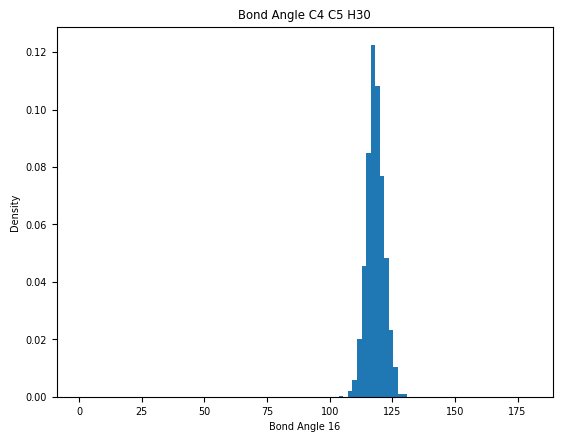

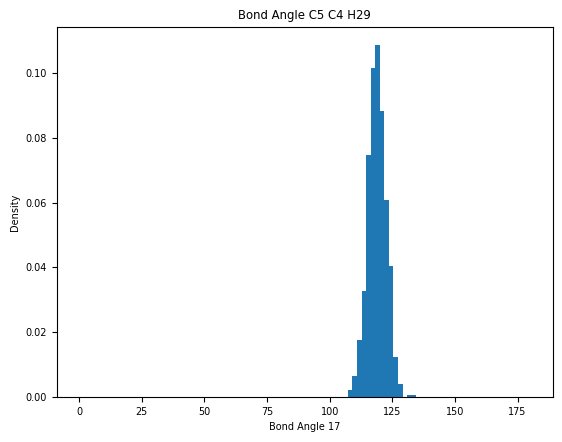

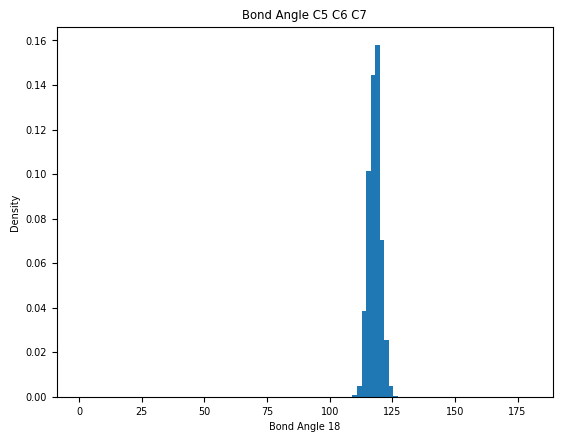

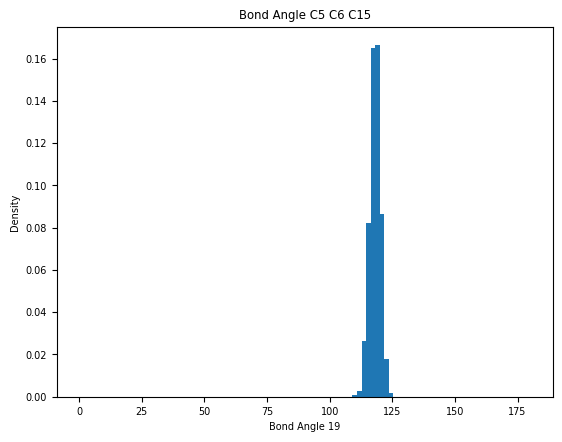

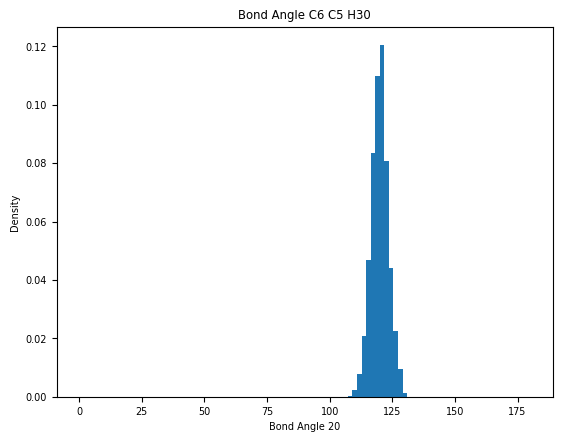

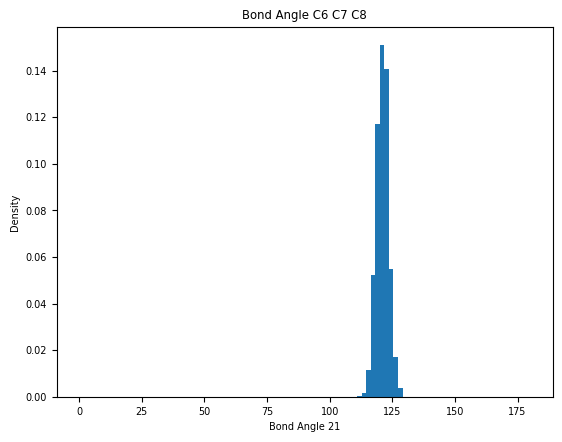

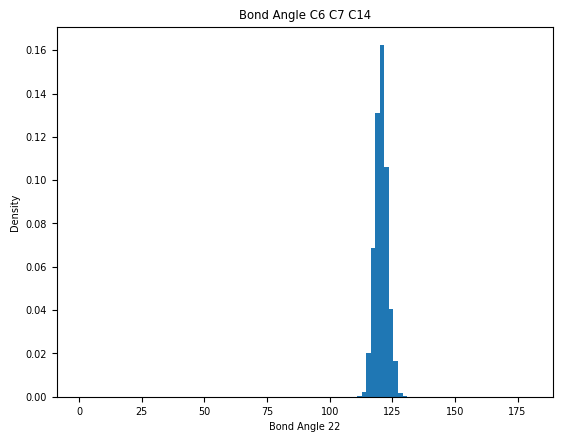

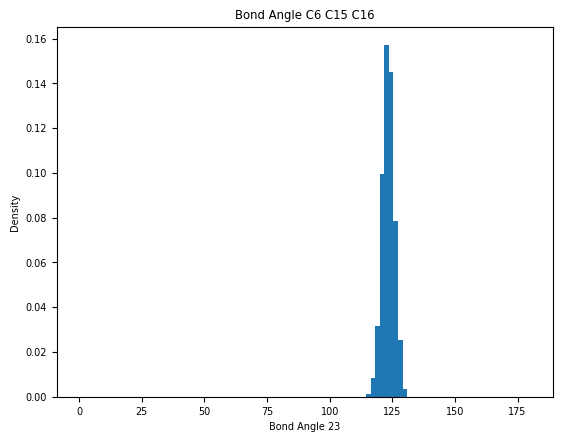

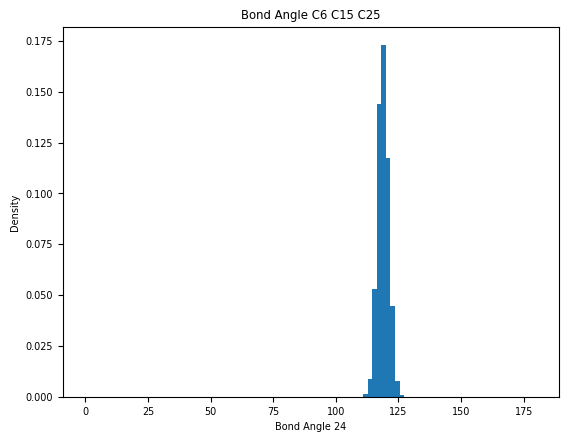

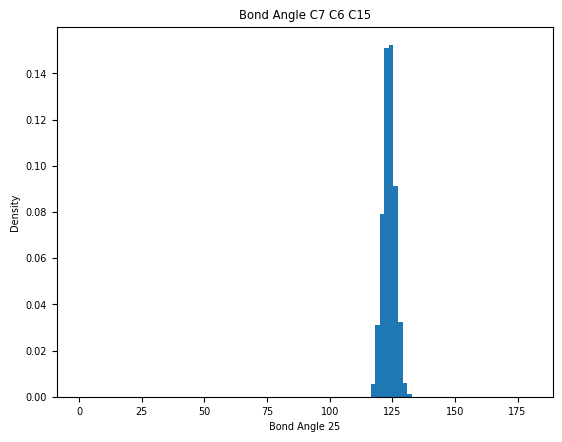

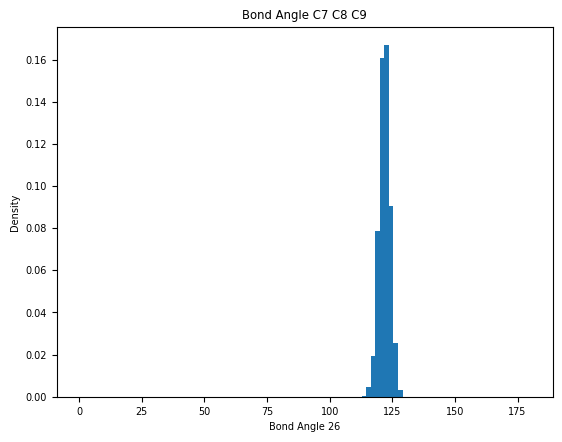

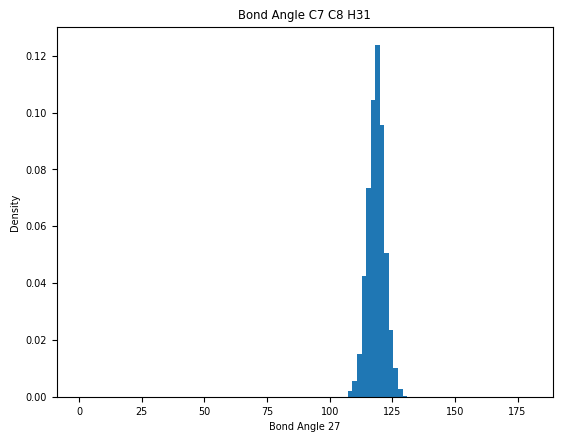

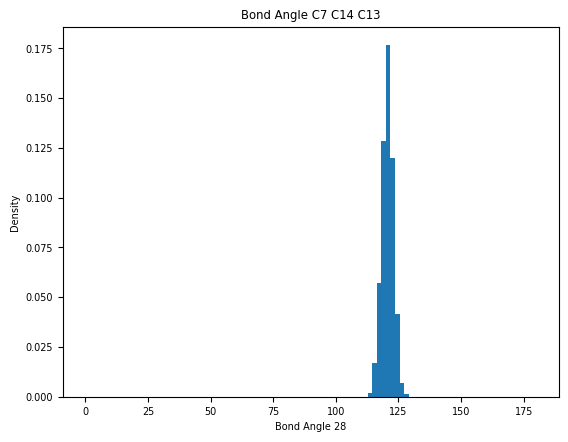

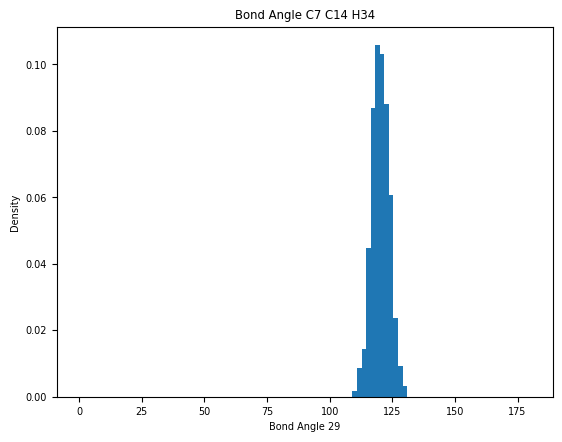

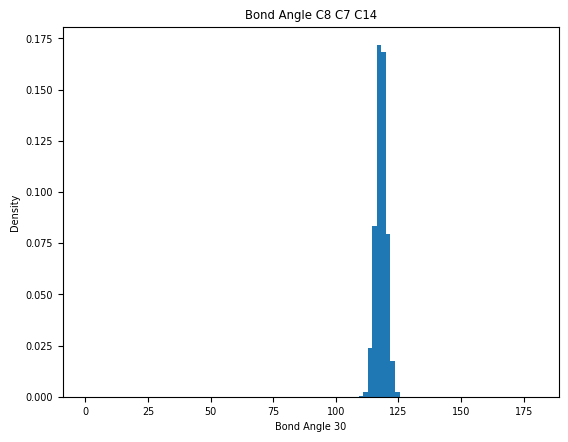

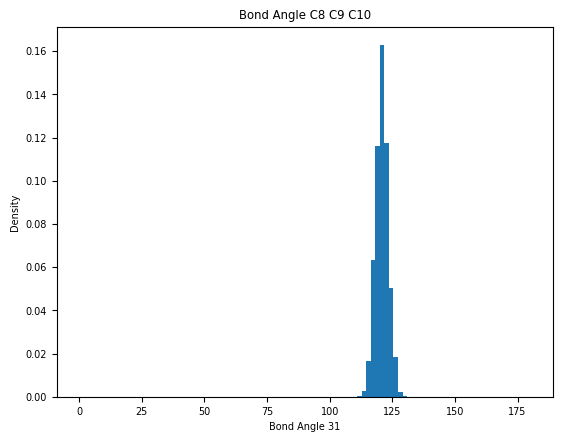

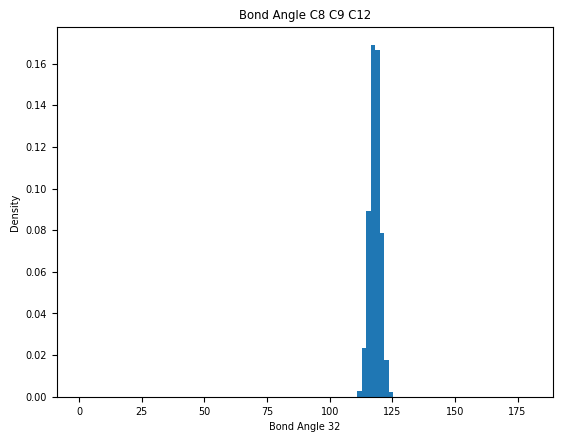

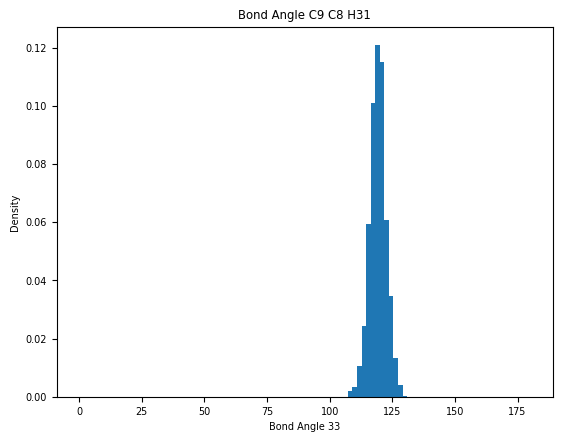

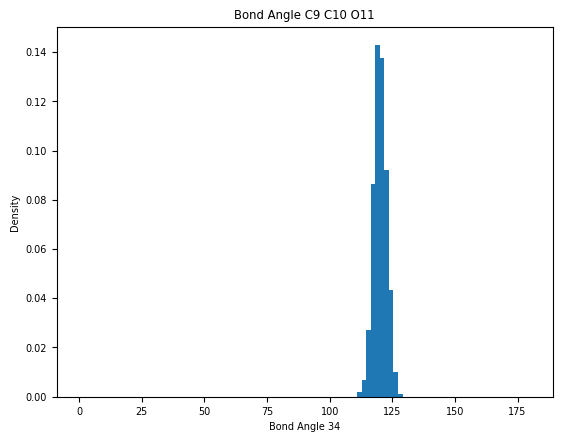

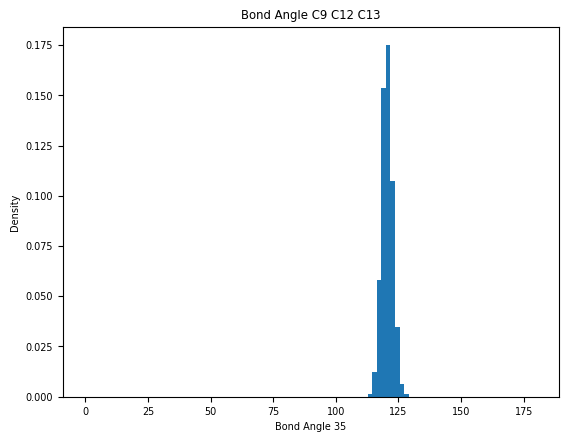

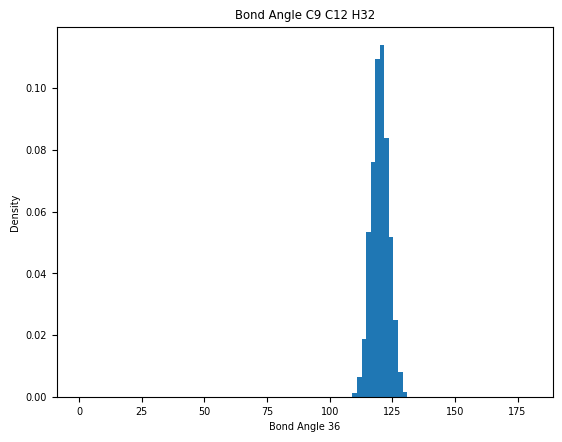

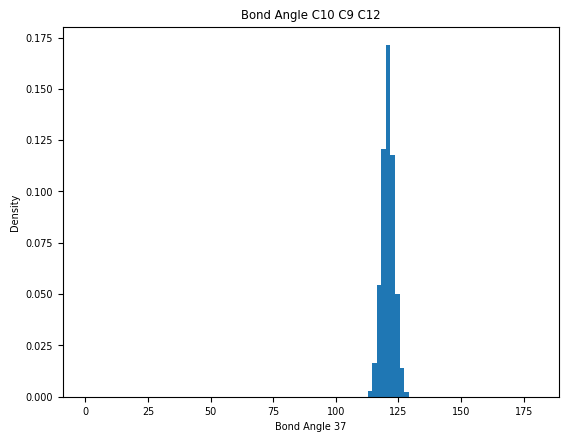

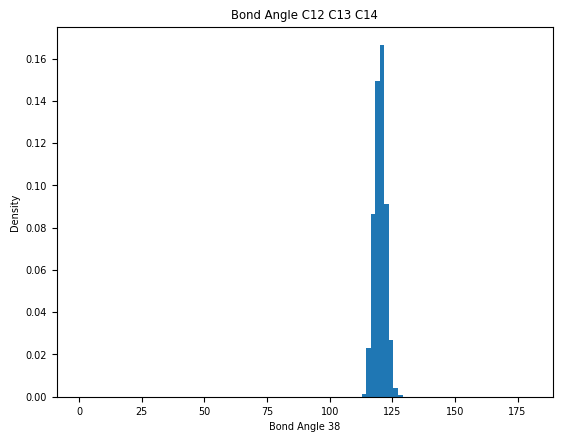

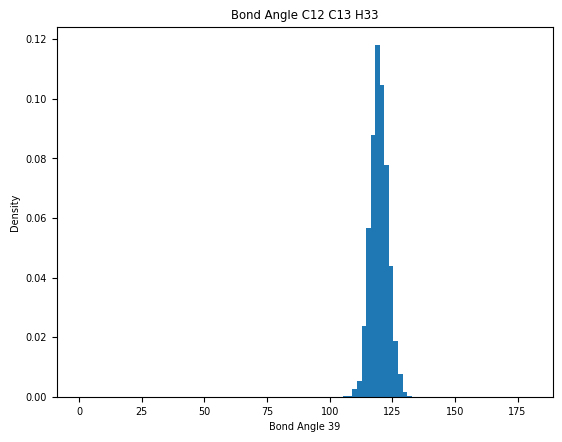

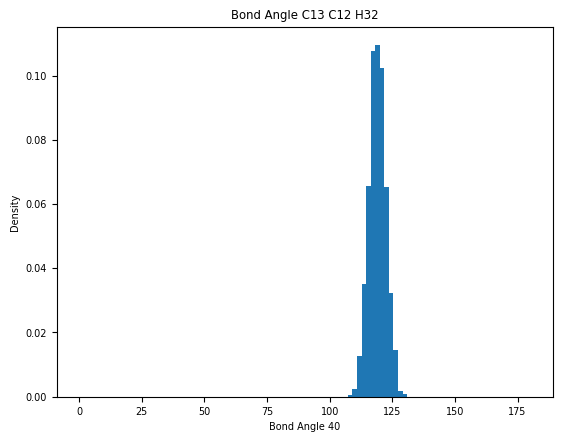

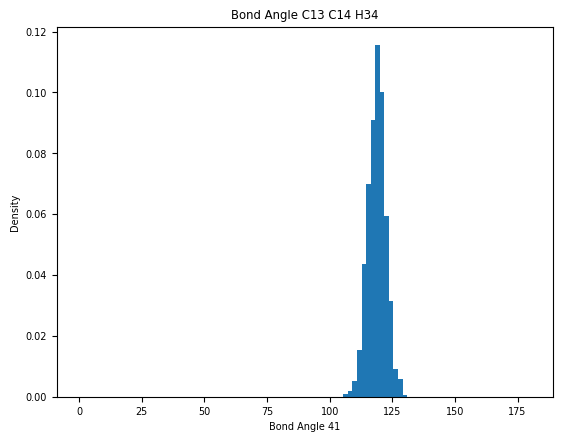

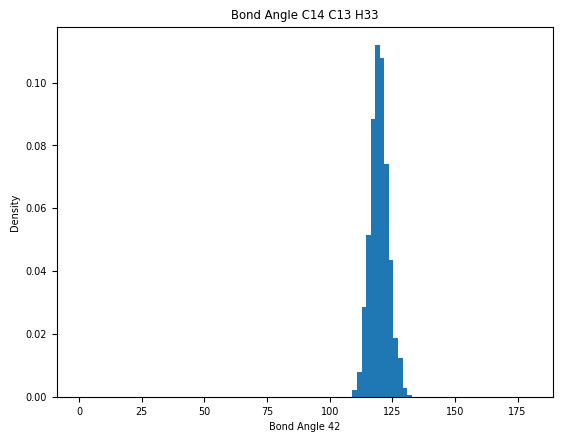

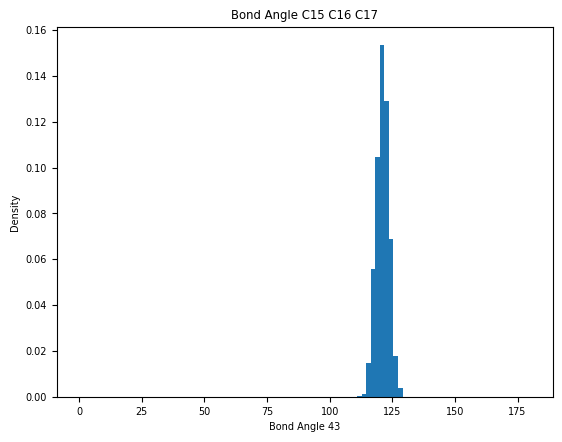

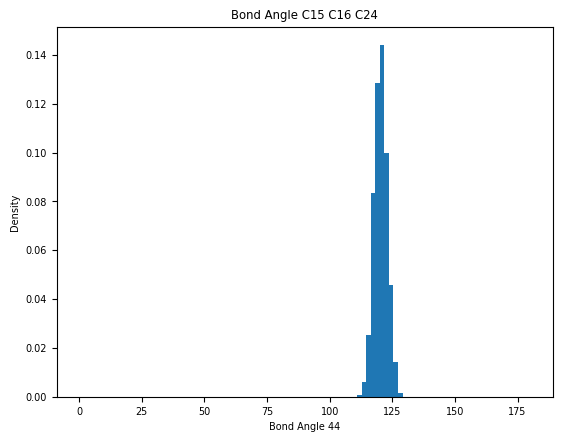

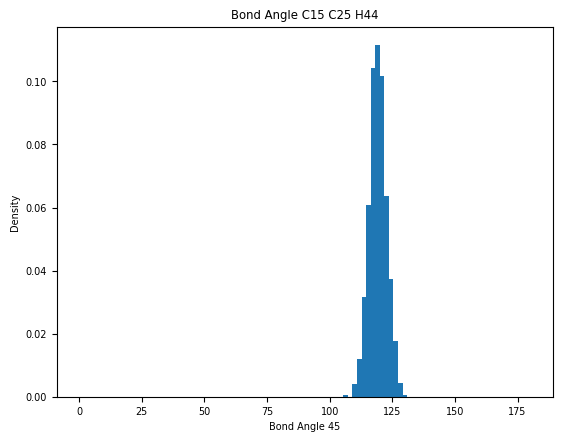

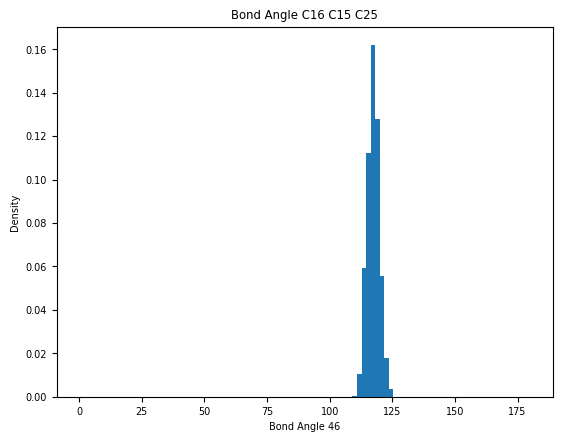

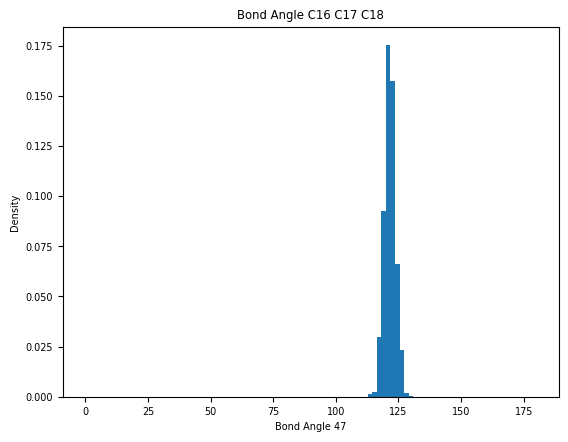

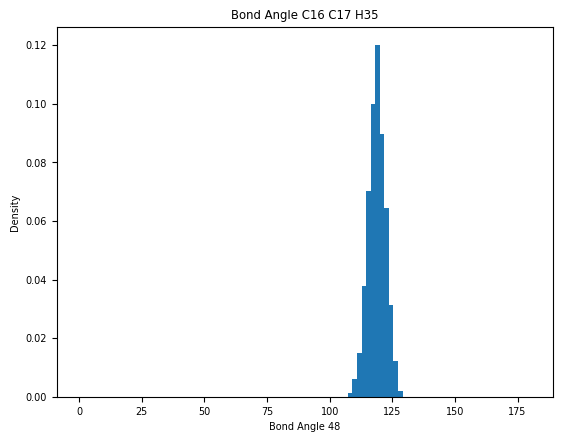

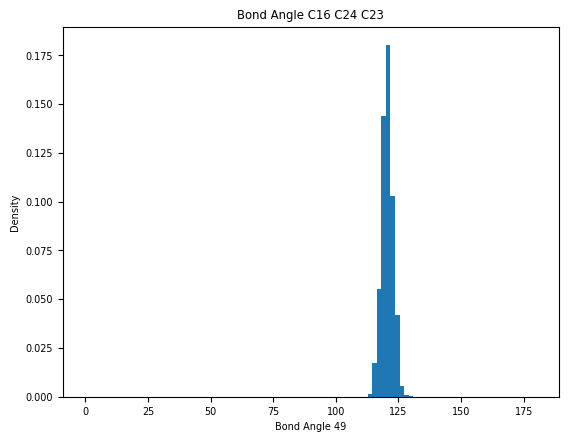

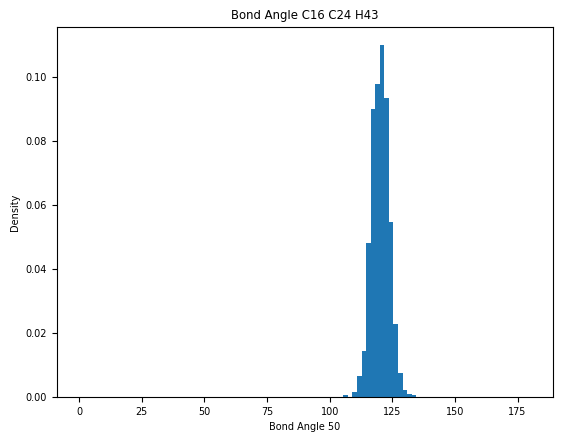

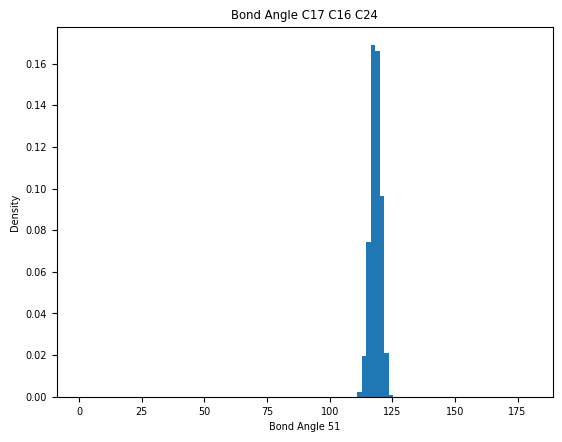

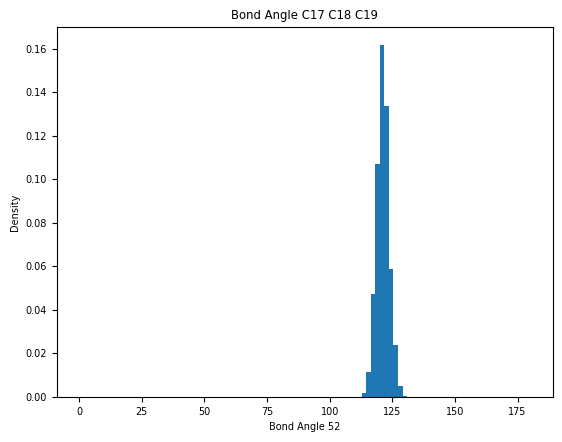

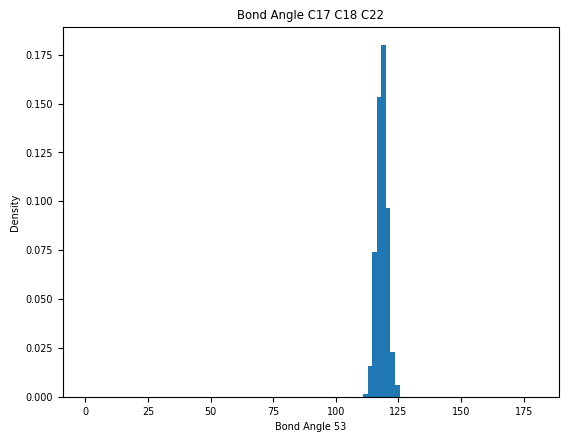

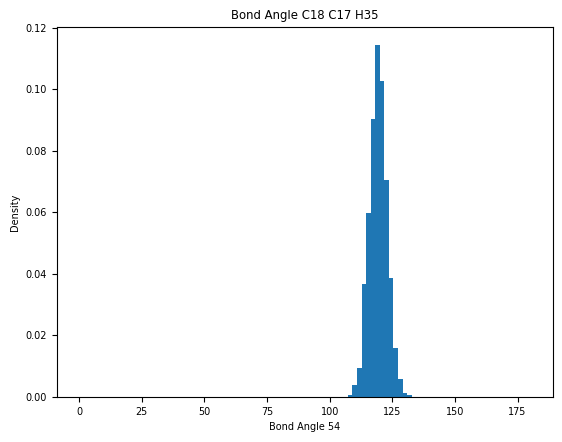

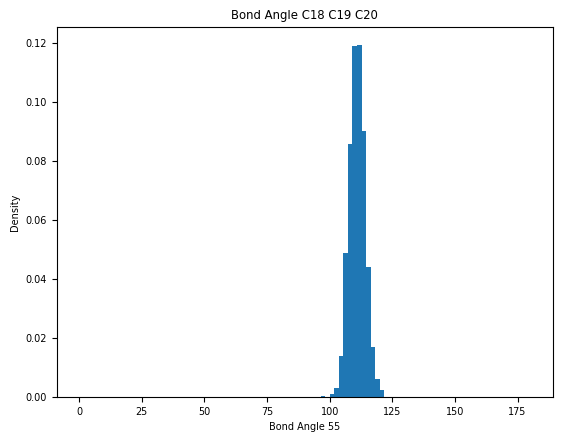

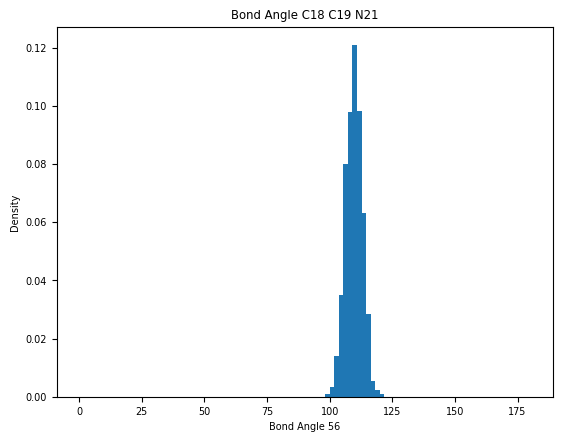

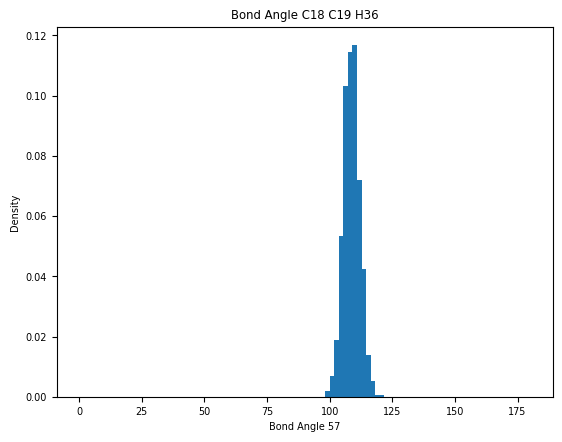

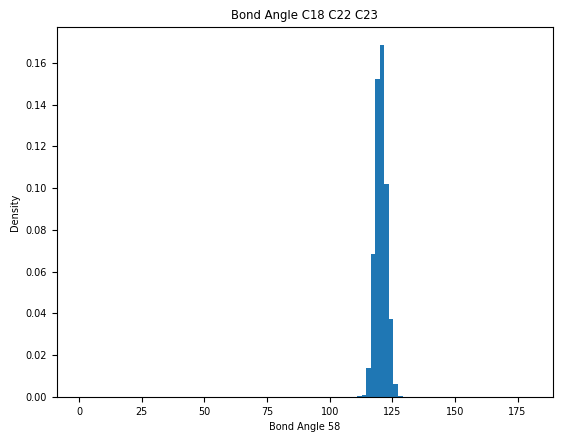

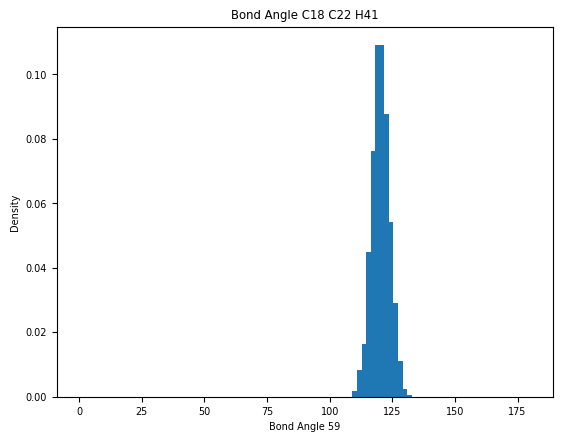

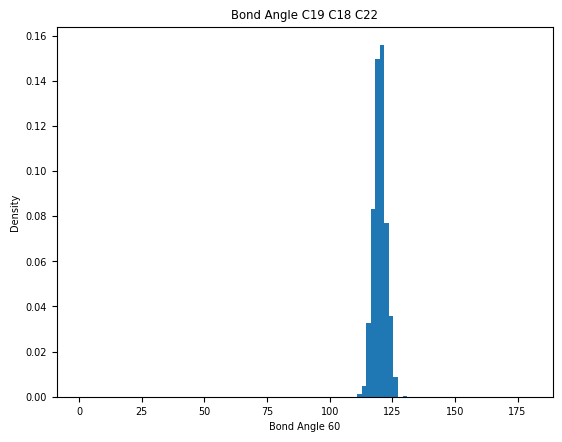

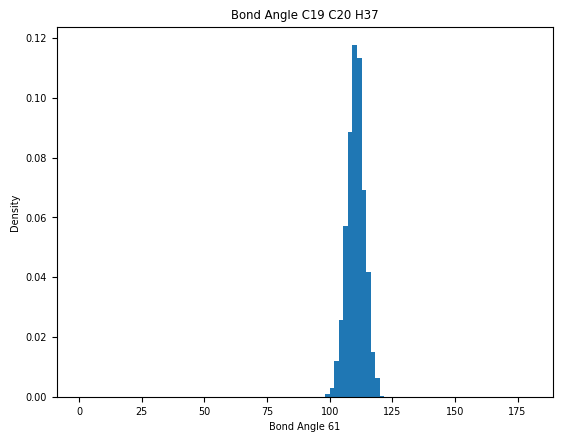

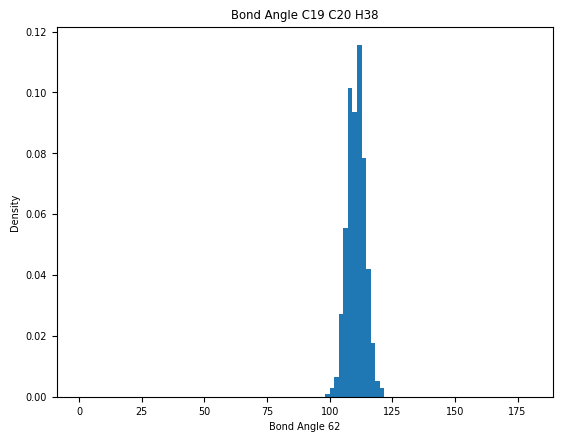

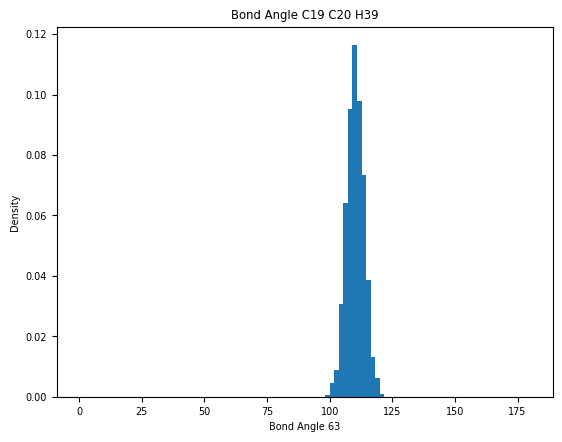

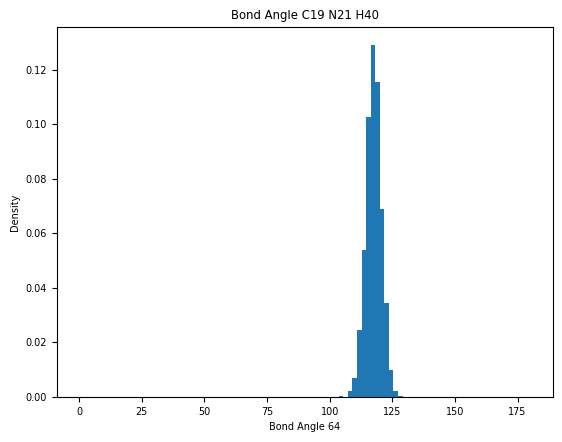

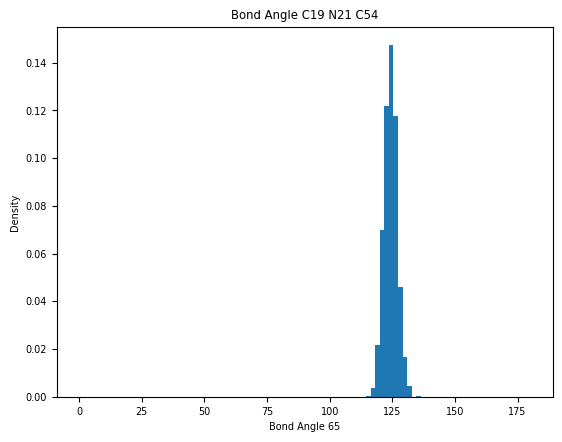

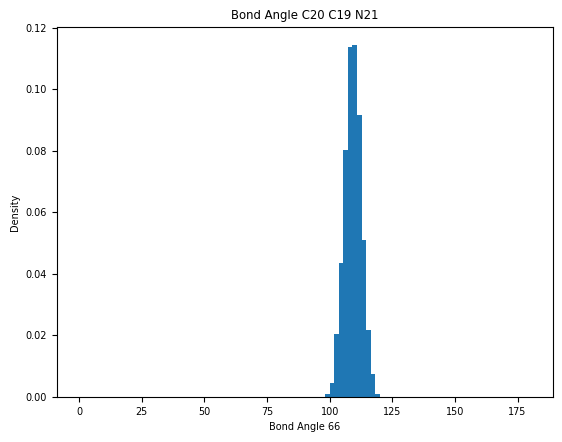

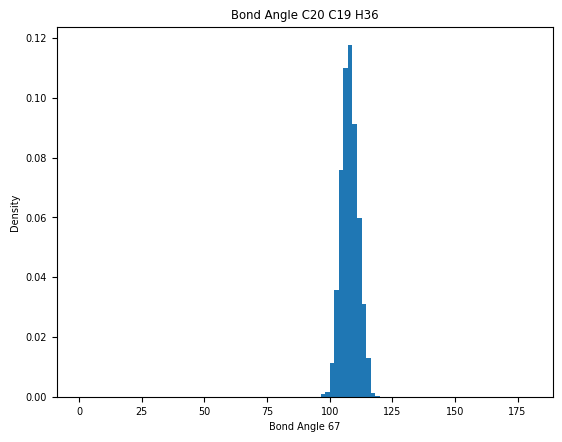

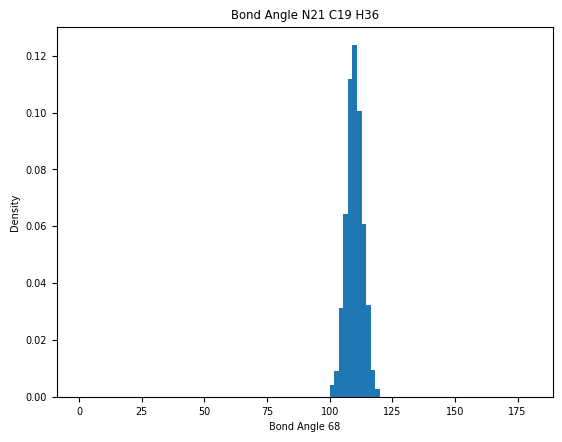

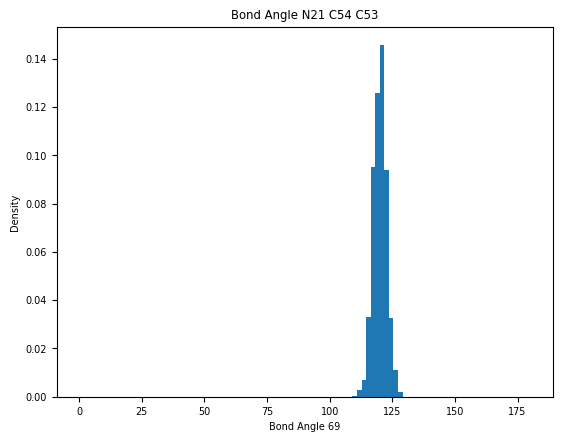

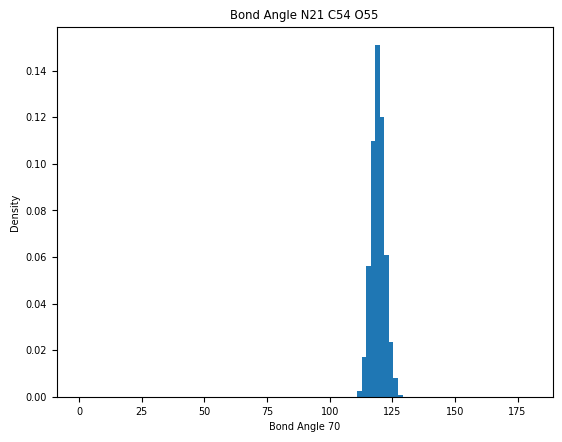

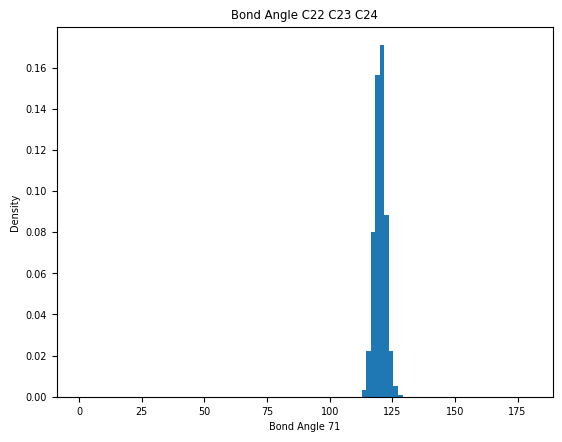

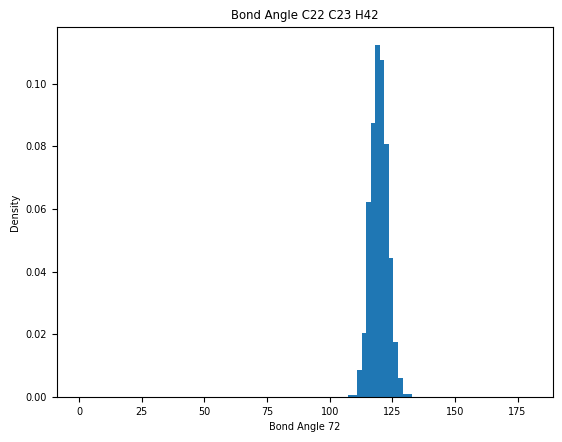

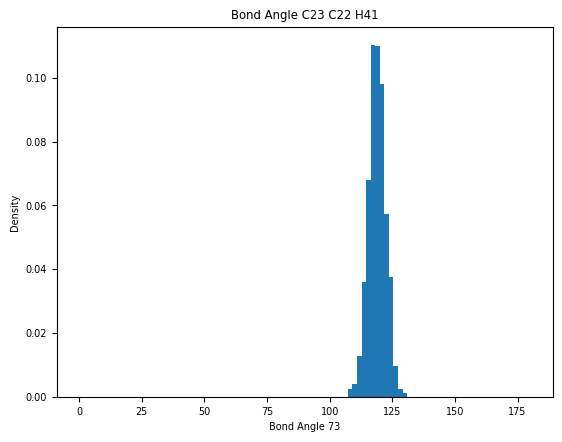

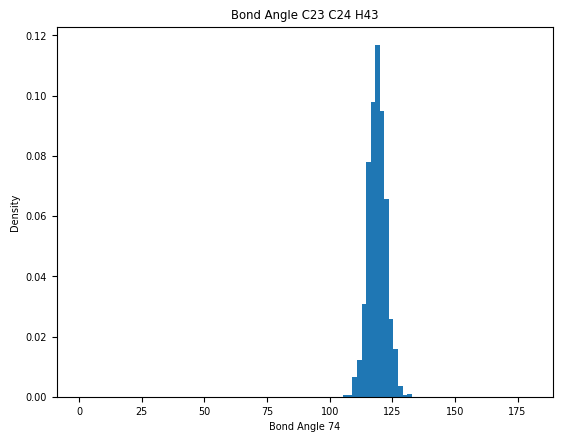

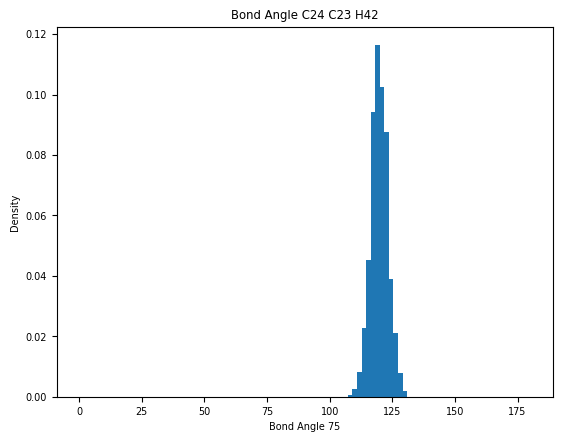

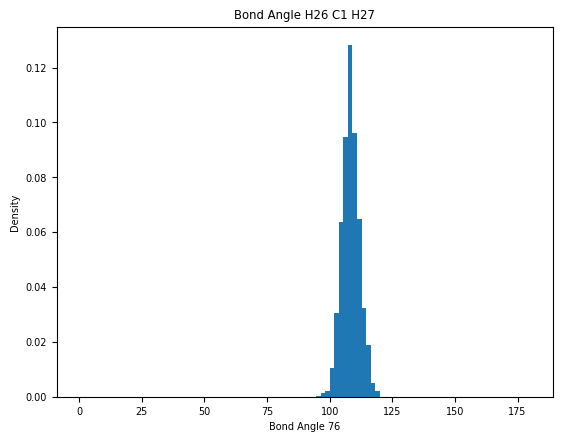

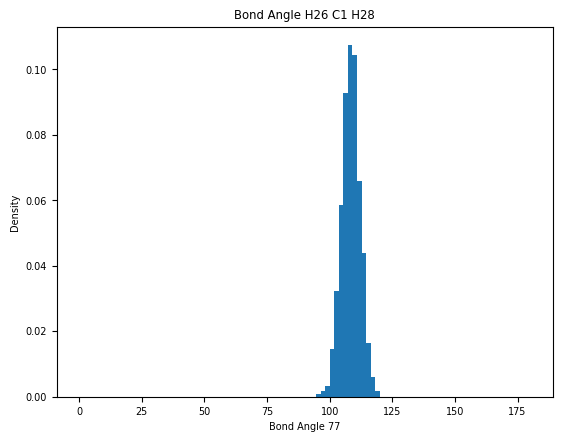

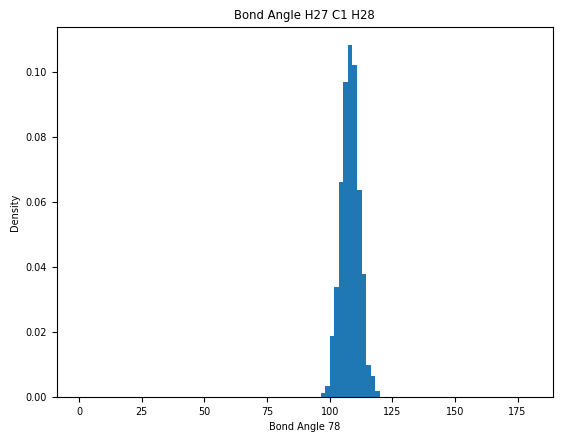

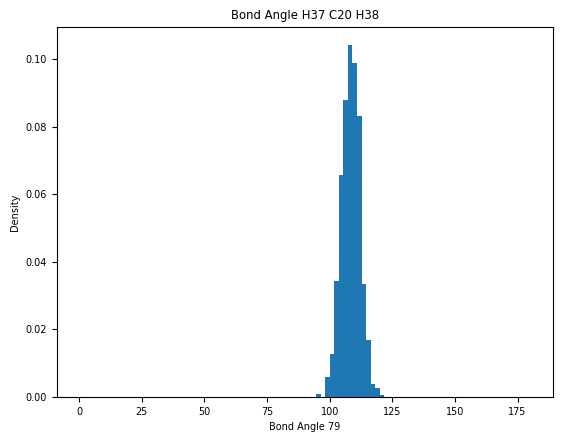

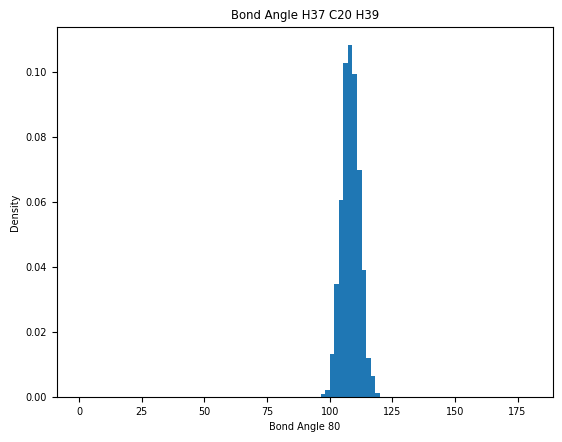

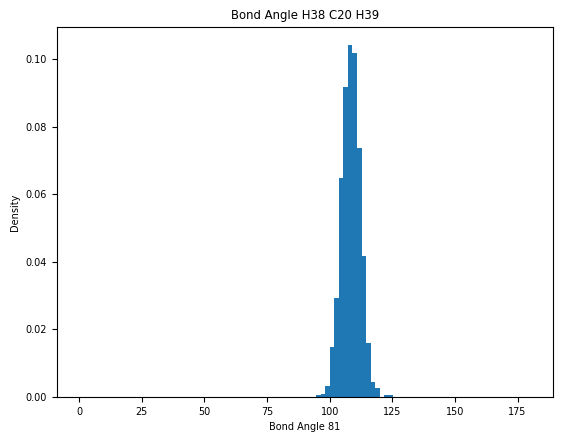

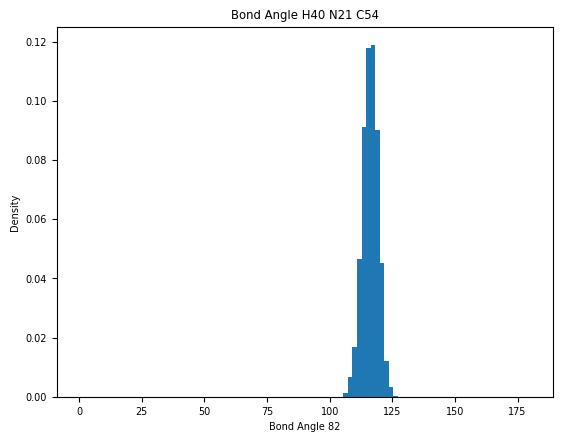

In [24]:
plot_distributions = True

ideal_bond_angles = []
for i in tqdm(range(len(hexamer_angles))):
    angle_values = []
    # Pull angles from residues 4, 5, 6 for all frames
    for ts in hexamer_helix_cluster.trajectory:
        hexamer_helix_cluster.atoms.positions = ts.positions
        for angle_id in hexamer_angles[i][-3:]:
            angle_index = all_angle_ids.index(angle_id)
            angle_values.append(hexamer_helix_cluster.angles[angle_index].value())
    # Plot histograms
    if plot_distributions:
        bin_edges = np.linspace(0, 180, 100)
        plt.figure()
        plt.hist(angle_values, bins = bin_edges, density=True)
        plt.title("Bond Angle " + " ".join(hexamer_angles[i][0]))
        plt.xlabel("Bond Angle " + str(i))
        plt.ylabel("Density")
        plt.close
    # Save average angle
    avg_angle = np.mean(angle_values)
    ideal_bond_angles.append(avg_angle)
ideal_bond_angles = np.array(ideal_bond_angles)

# Helix Reconstruction using helix torsions and angles

Using the torsions and angles identified above we can construct the helix in each residue using our `InternalCoordinateEditor` object. This object lets us set all torsions within the model to the helical internal coordinates found above.

In [26]:
# InternalCoordinateEditor for Hexamer
# We run these together to ensure we start with a minimized structure

ice = hs.edit_conf.InternalCoordinateEditor("mom_octamer_mbuild_off-2.0.0.gro", "mom_octamer_mbuild_off-2.0.0.itp")

for i, res_torsions in enumerate(all_octamer_torsions):
    for res_torsion in res_torsions:
        torsion_ids, torsion_values = ice.find_torsions(res_torsion)
        if len(torsion_ids) != 0:
            if res_torsion == torsion_ids[0]:
                ice.set_torsion(torsion_ids[0], (ideal_torsions[i]) * np.pi / 180)
            else:
                ice.set_torsion(torsion_ids[0], (ideal_torsions[i]) * np.pi / 180)
            
for i, res_angles in enumerate(octamer_angles):
    for res_angle in res_angles:
        ice.set_angle(res_angle, ideal_bond_angles[i] * np.pi/180)


shift = ice.torsions[ice.bat._primary_torsion_indices]
shift[ice.bat._unique_primary_torsion_indices] = 0
ice.torsions -= shift
                
ice.update_internal_coordinates()
ice.write_structure("mom_octamer_helix.gro")

/home/tfobe/anaconda3/envs/hs_analysis/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:447: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


['H40', 'N21', 'C54'] is not a valid angle ID.
['H84', 'N65', 'C98'] is not a valid angle ID.
['H128', 'N109', 'C142'] is not a valid angle ID.
['H172', 'N153', 'C186'] is not a valid angle ID.
['H216', 'N197', 'C230'] is not a valid angle ID.
['H260', 'N241', 'C274'] is not a valid angle ID.
['H304', 'N285', 'C318'] is not a valid angle ID.


# Comparing Ideal Helix (after minimization) to current torsions/angles

In [29]:
!gmx grompp -f em.mdp -c mom_octamer_helix.gro -p mom_octamer_mbuild_off-2.0.0.top -o em_octamer_helix
!gmx mdrun -deffnm em_octamer_helix

                      :-) GROMACS - gmx grompp, 2022.4 (-:

Executable:   /usr/local/bin/gmx
Data prefix:  /usr/local
Working dir:  /mnt/curc/simulations/terphenyl_mom/octamer_md/build_system
Command line:
  gmx grompp -f em.mdp -c mom_octamer_helix.gro -p mom_octamer_mbuild_off-2.0.0.top -o em_octamer_helix

Ignoring obsolete mdp entry 'title'
Setting the LD random seed to 2095831142

Generated 69751 of the 69751 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5

Generated 69751 of the 69751 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'mom_octamer_mbuild.pdb'
Analysing residue names:
There are:    10      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Number of degrees of freedom in T-Coupling group rest is 1116.00

NOTE 1 [file em.mdp]:
  You are using a plain Coulomb cut-off, which might produce artifacts.
  You might want to consider using PME electrostatics.



This run wil

In [32]:
ideal_helix_conf = mda.Universe("mom_octamer_mbuild_off-2.0.0.itp", "em_octamer_helix.gro")

 24%|██████████▏                               | 30/123 [03:26<10:40,  6.89s/it]/tmp/ipykernel_24153/3979980141.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
100%|█████████████████████████████████████████| 123/123 [16:09<00:00,  7.88s/it]


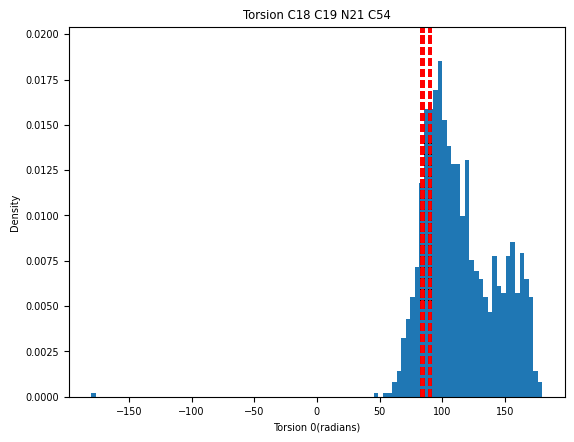

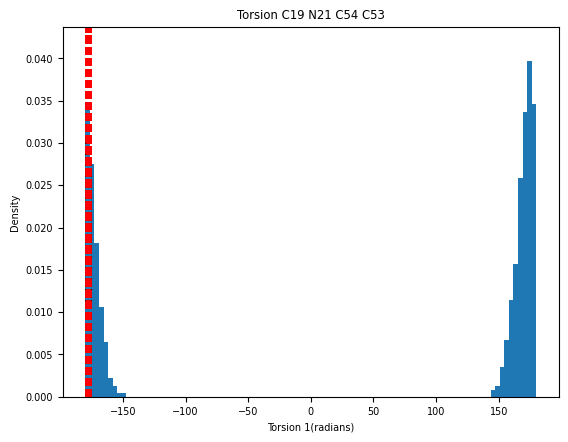

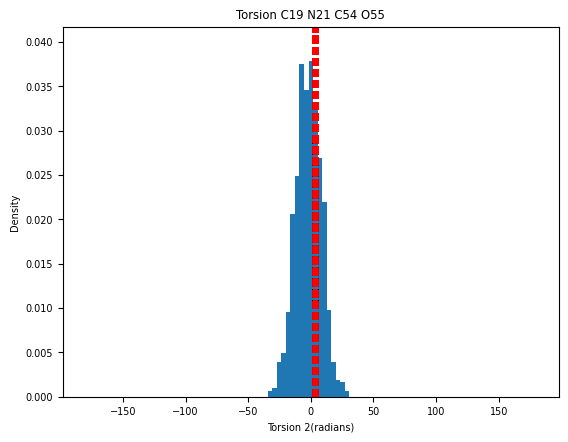

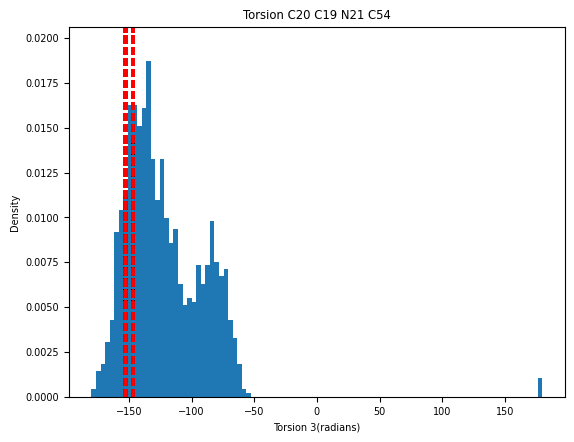

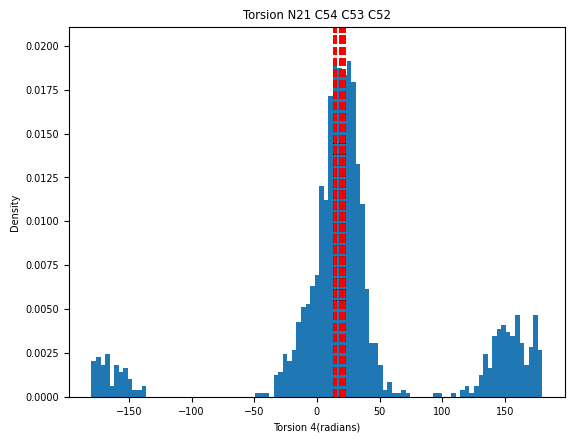

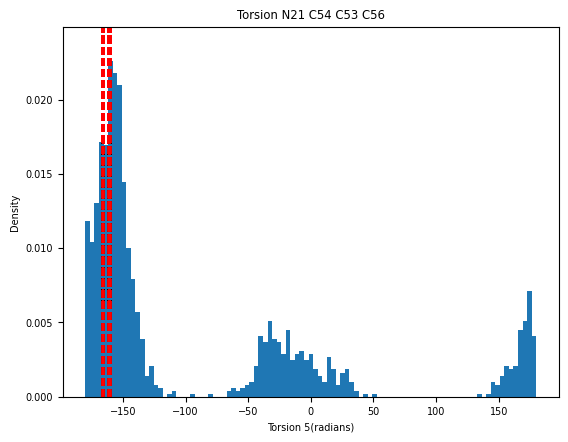

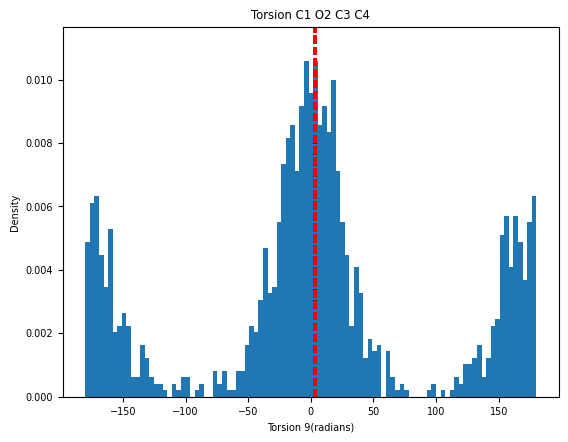

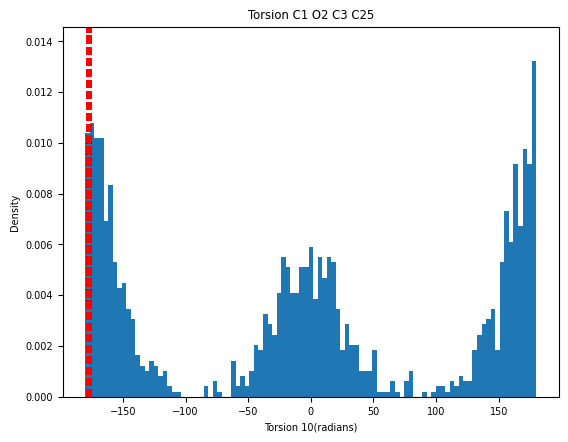

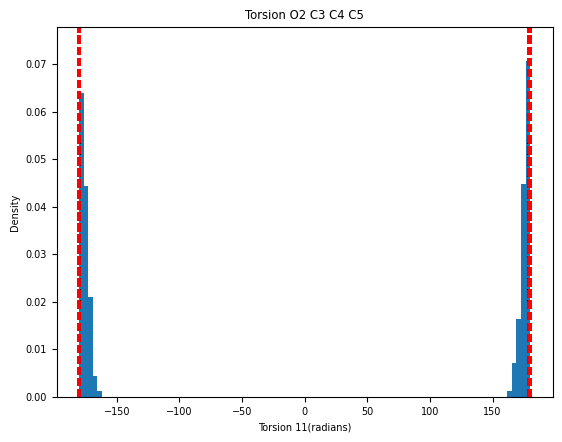

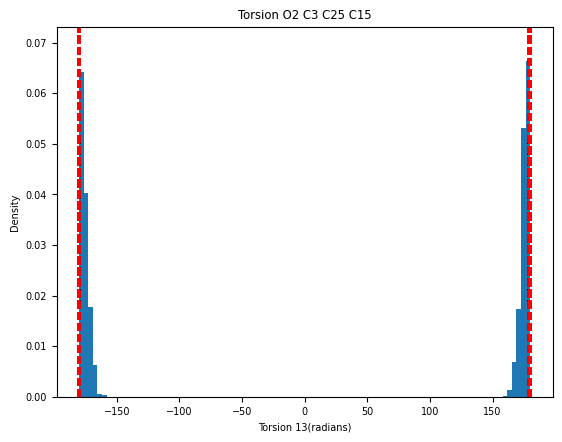

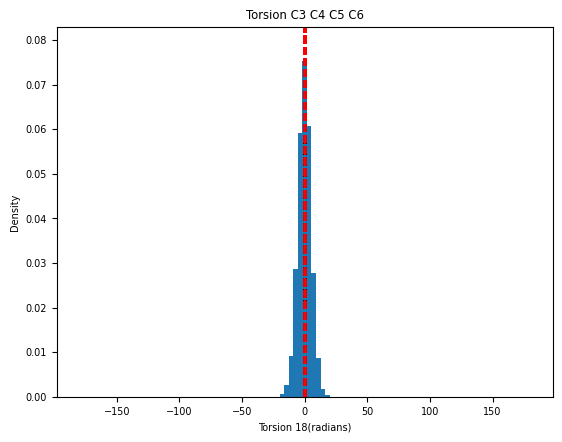

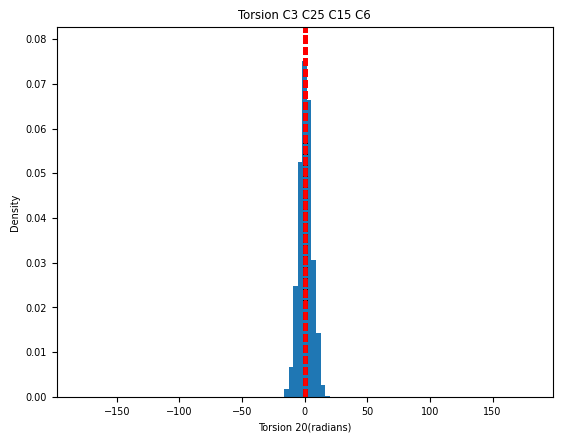

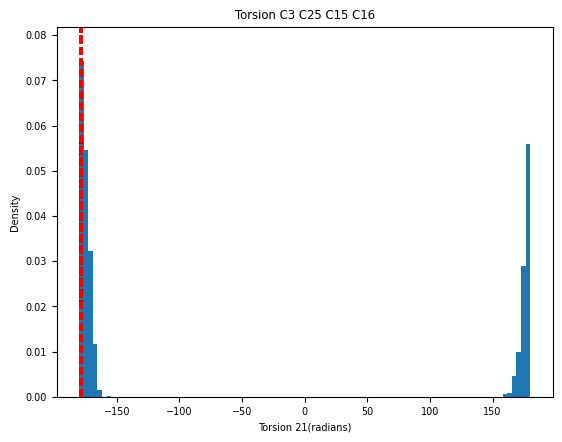

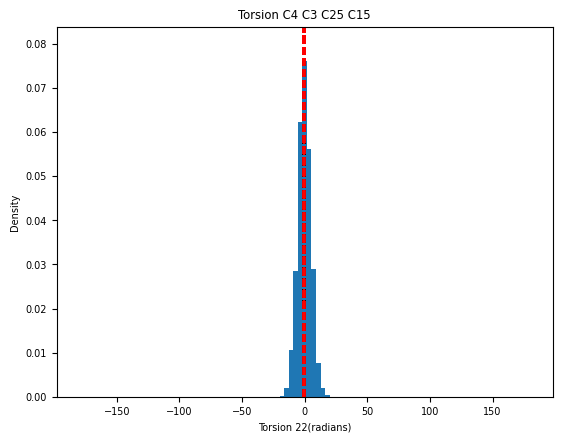

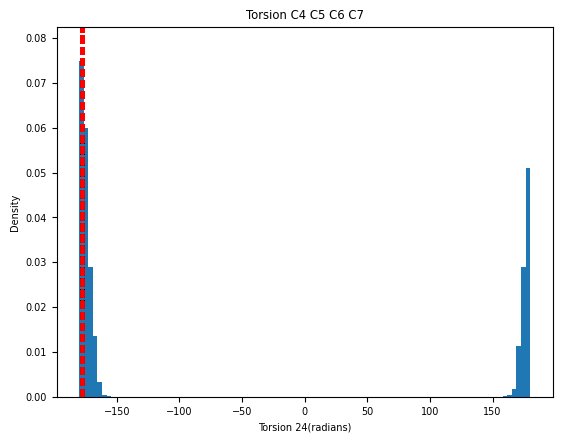

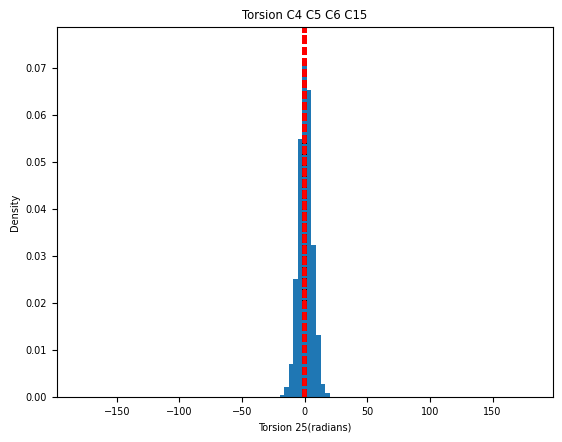

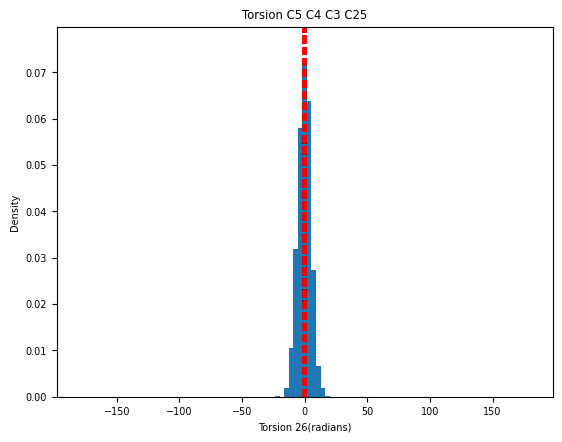

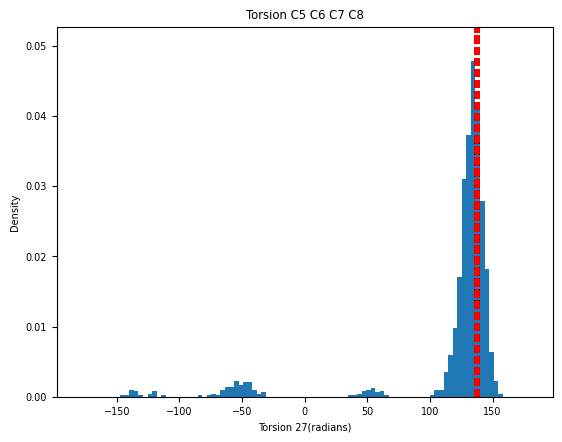

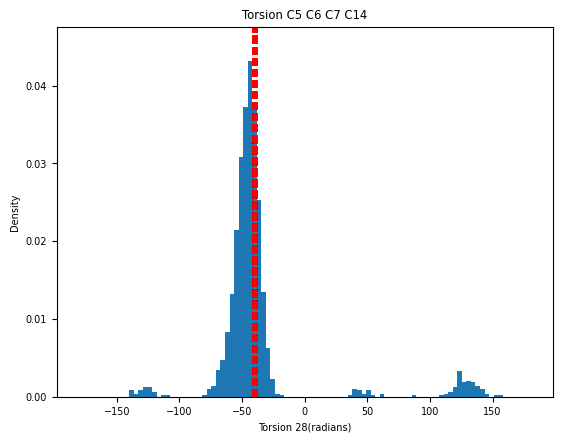

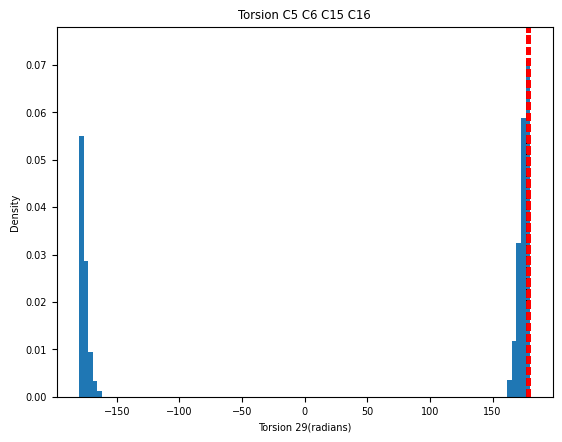

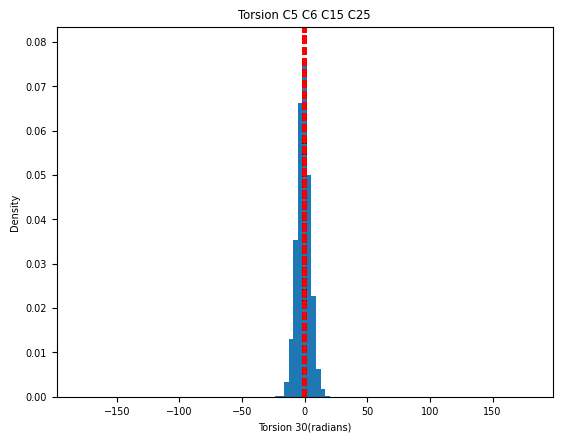

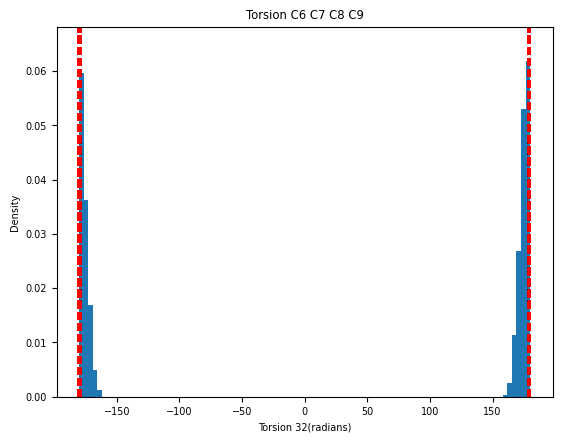

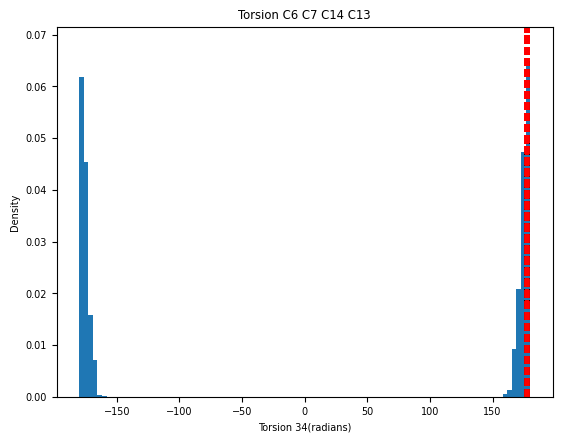

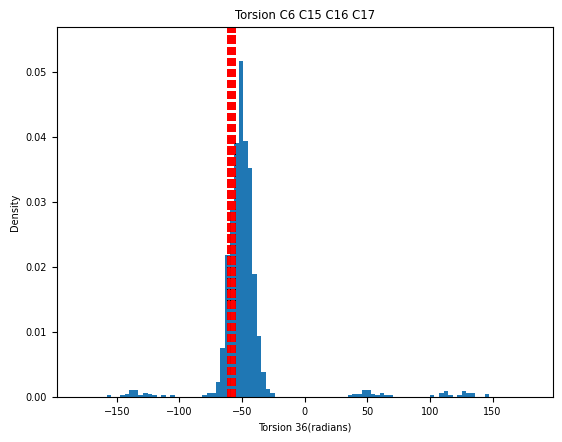

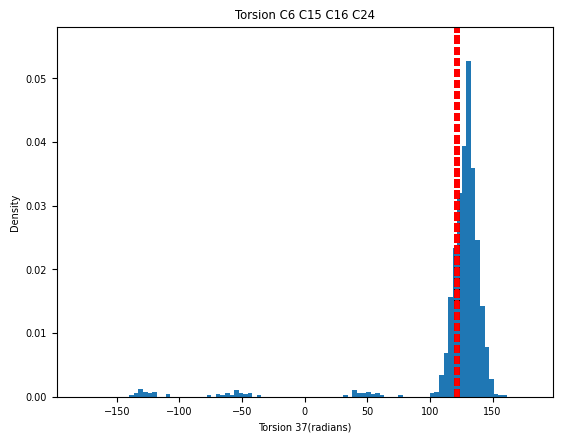

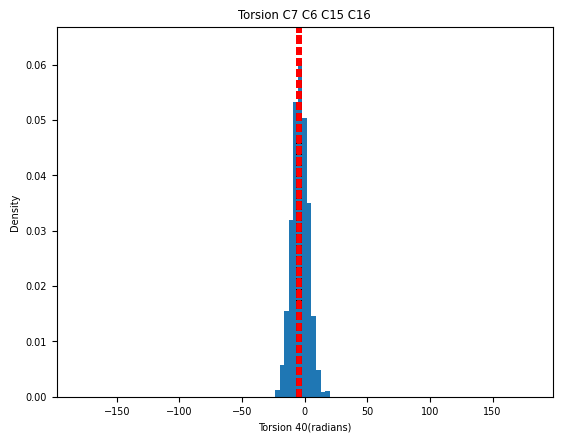

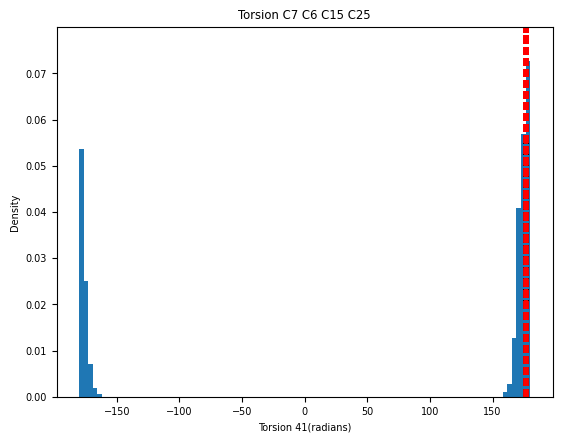

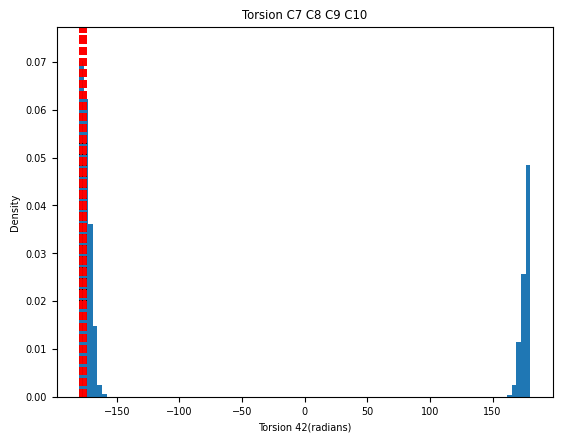

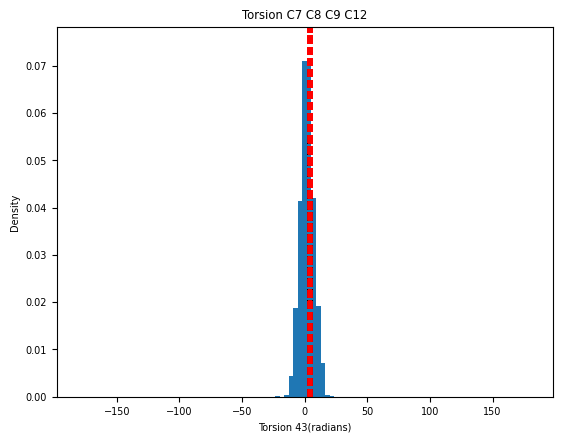

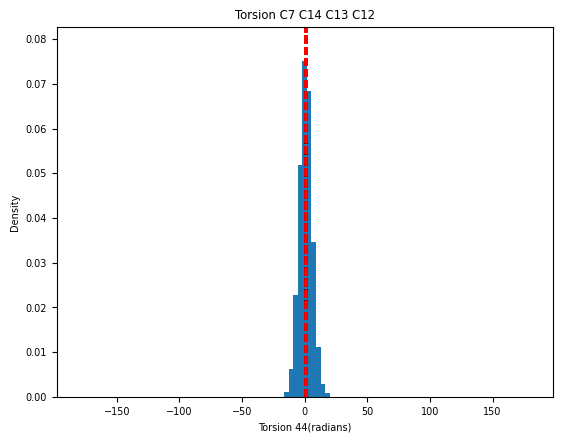

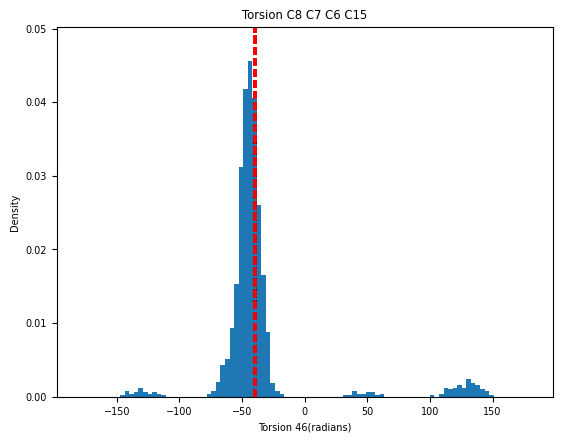

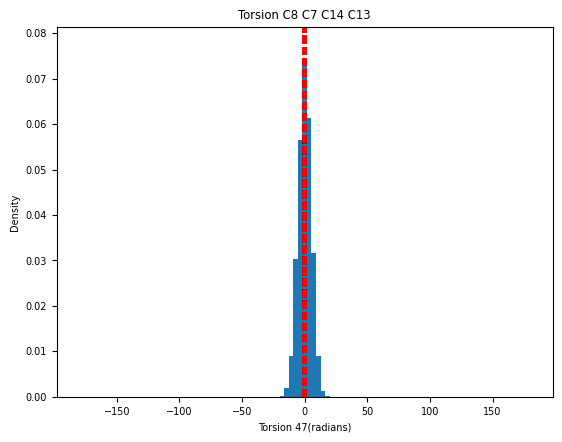

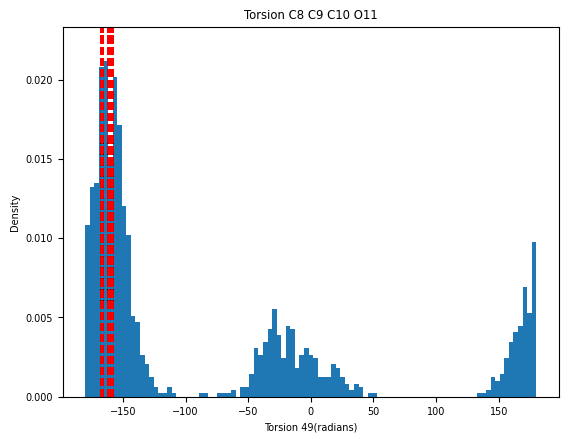

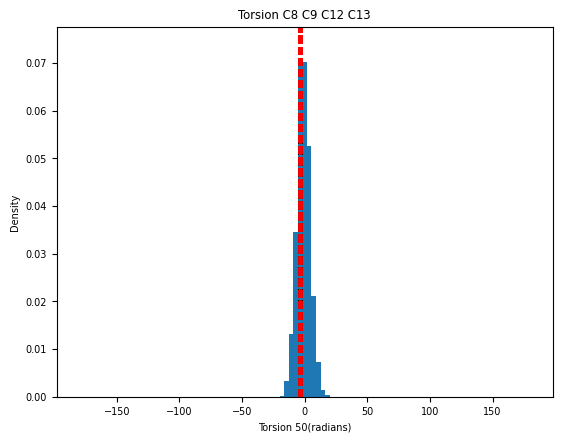

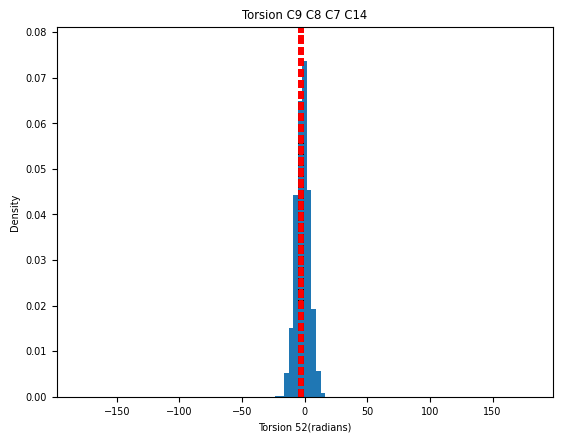

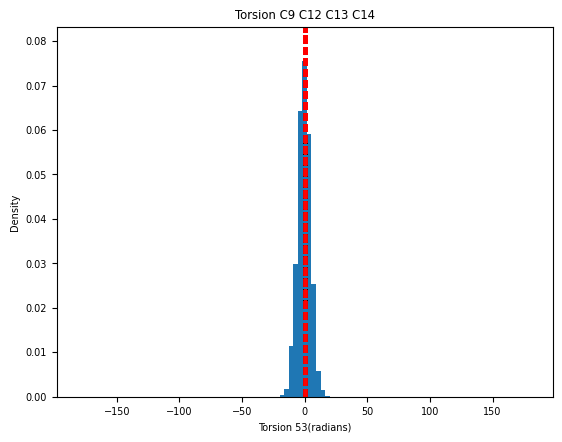

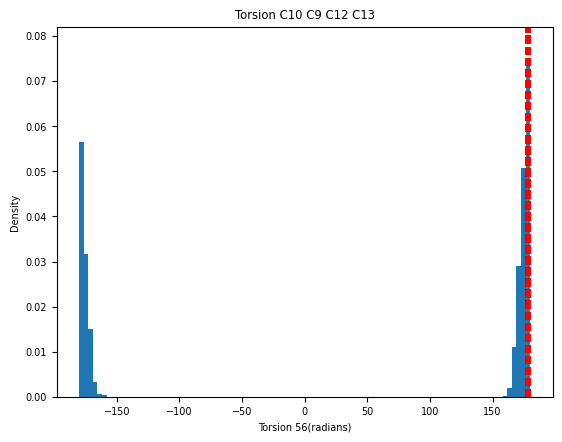

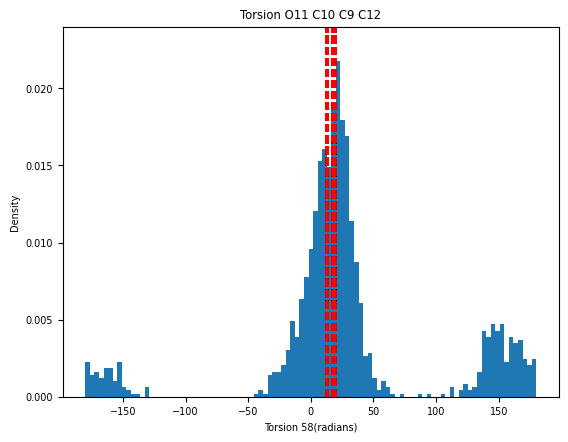

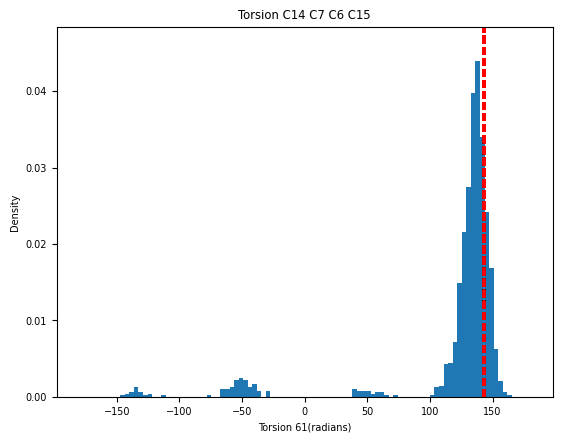

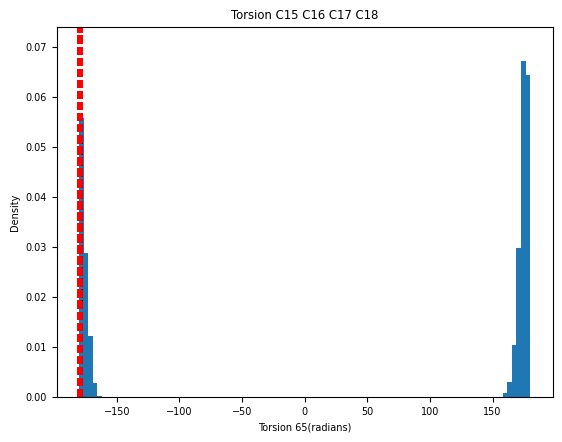

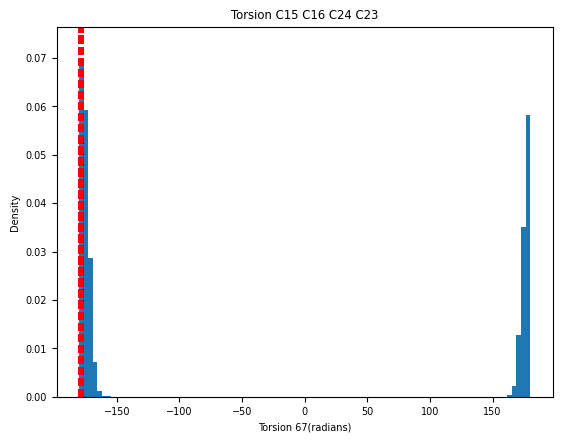

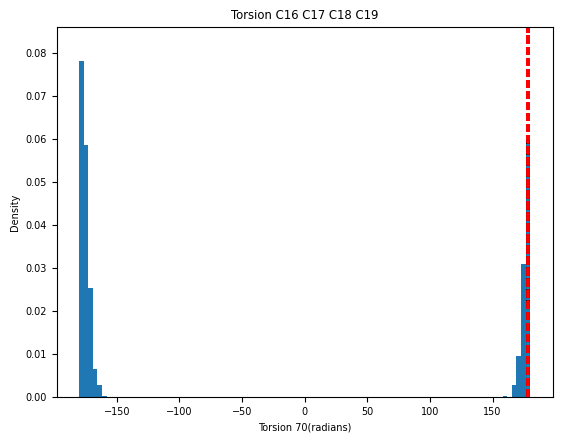

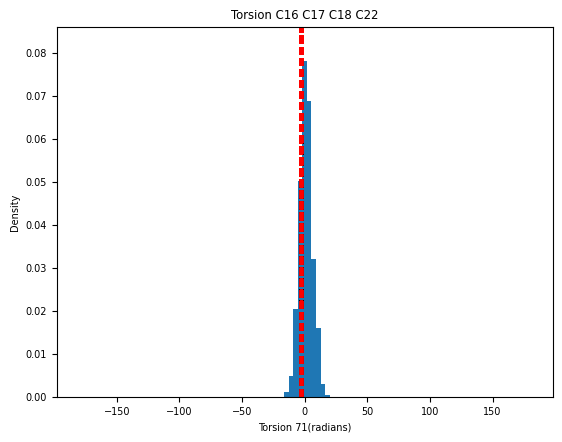

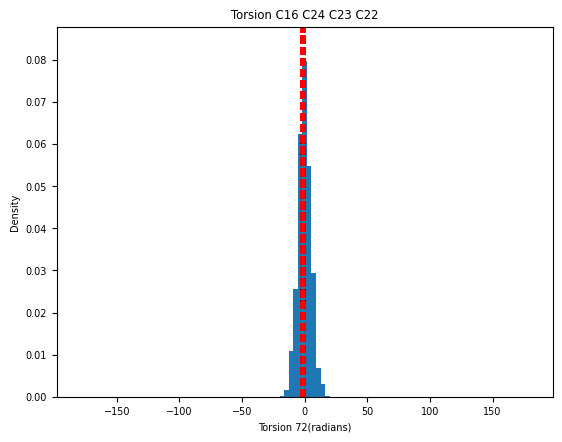

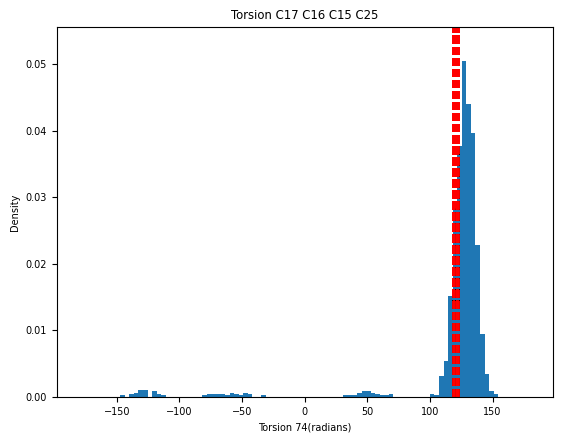

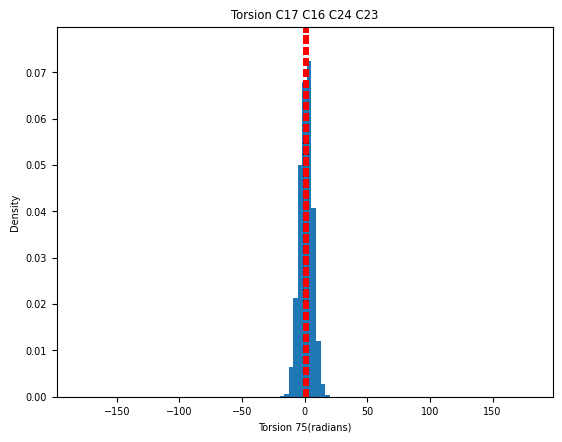

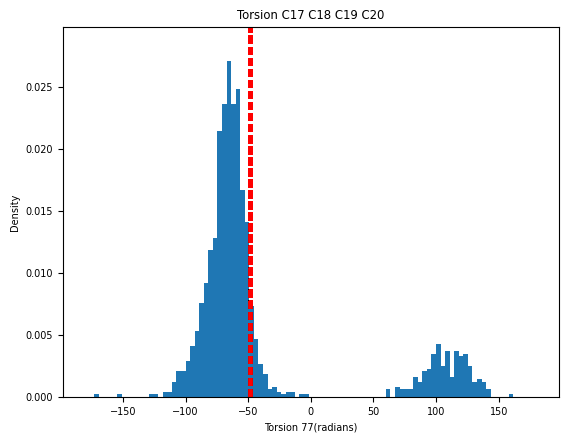

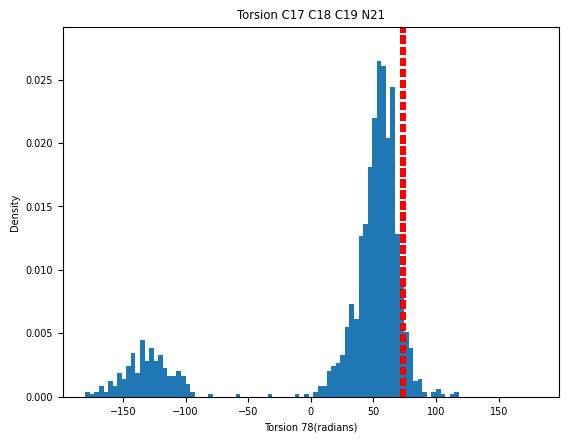

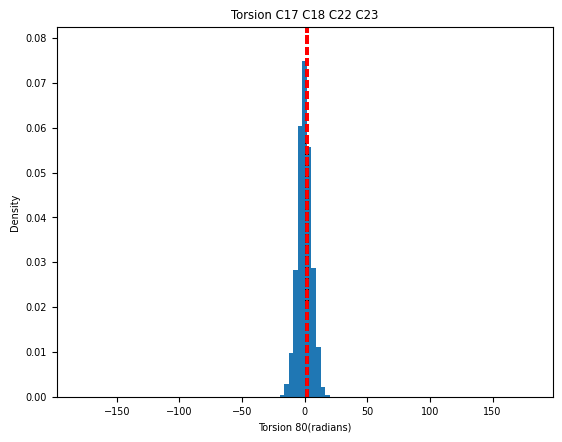

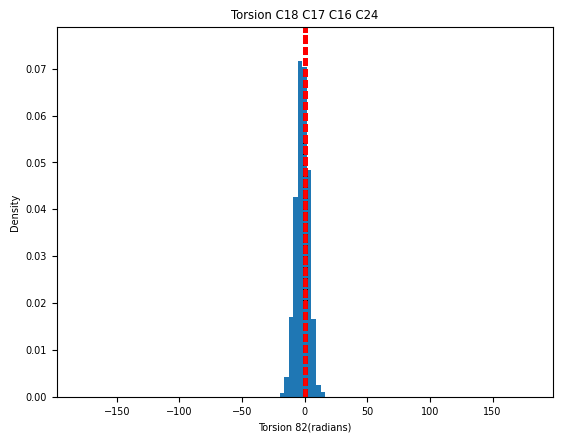

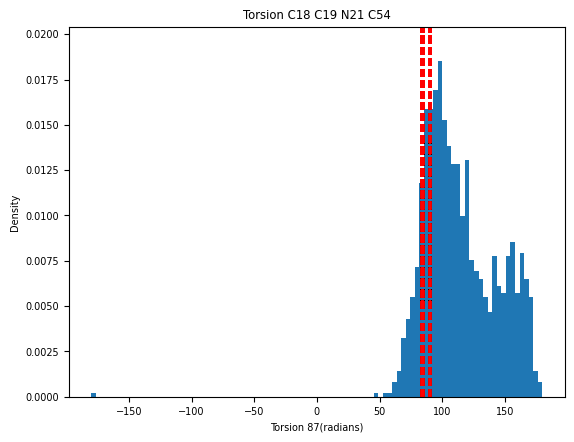

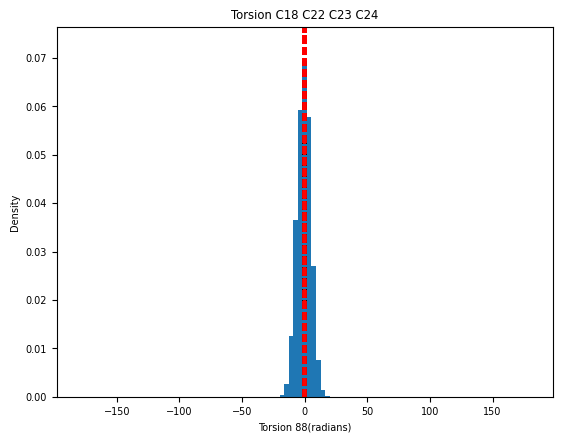

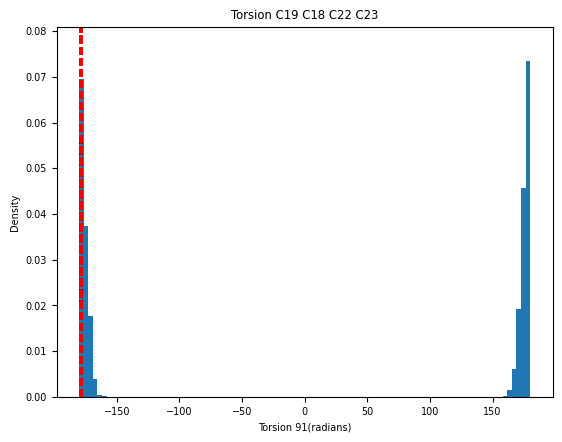

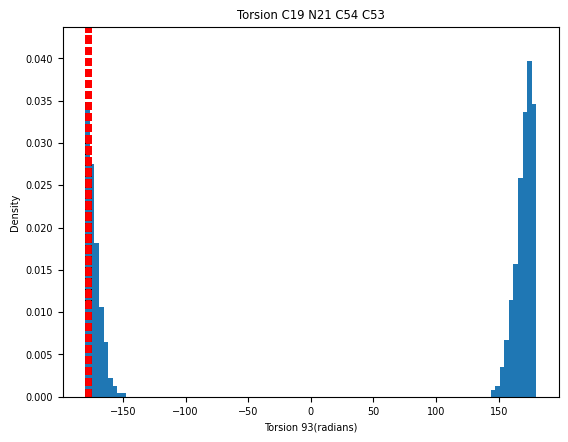

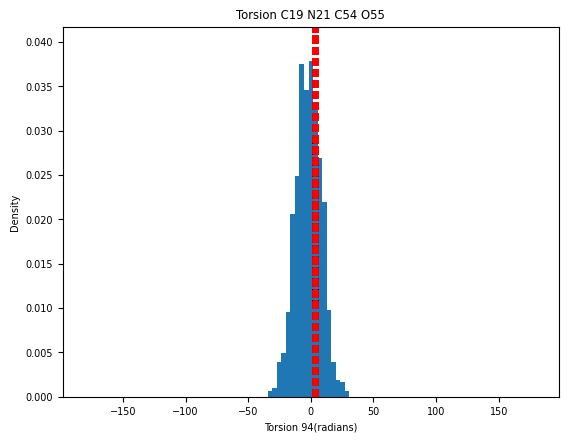

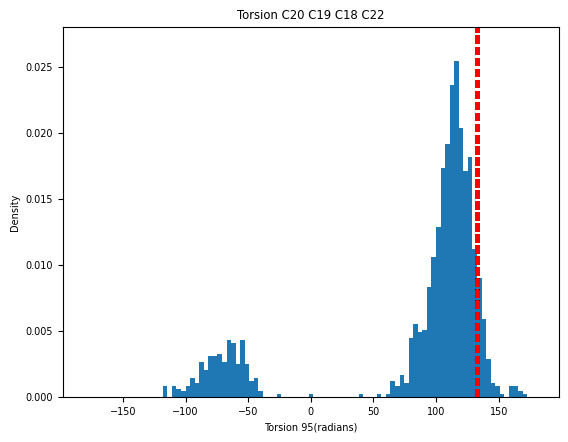

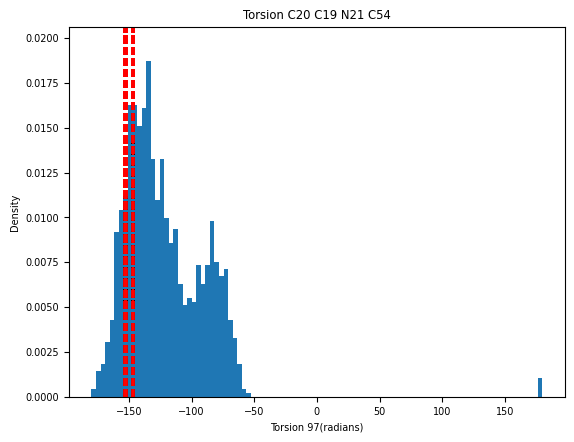

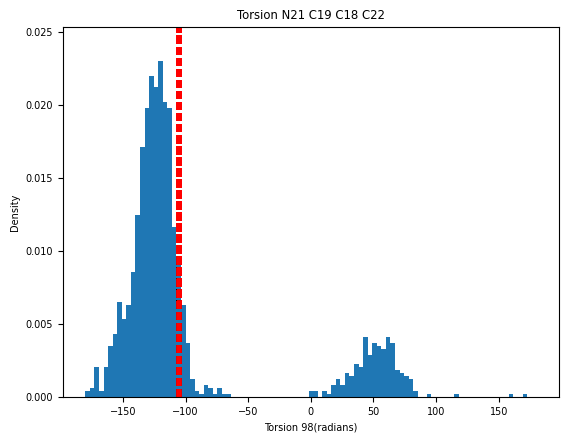

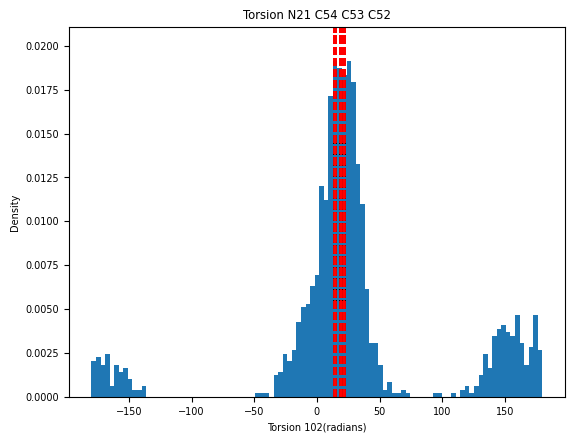

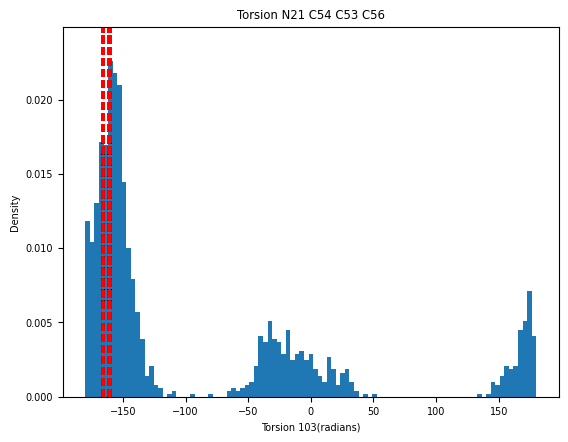

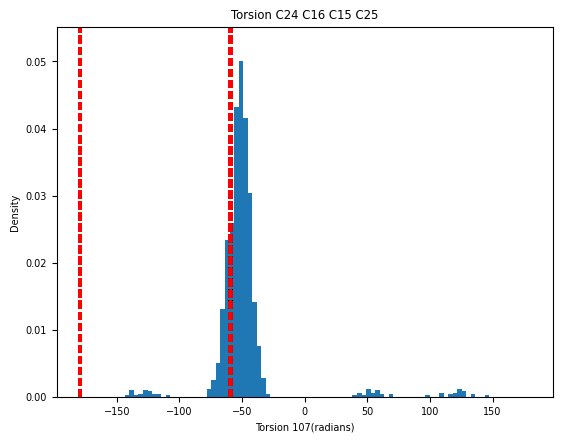

In [33]:
# Now we extract all torsions of the helical segment in the hexamer

plot_distributions = True

ideal_torsions = []
for i in tqdm(range(len(all_hexamer_torsions))):
    torsion_values = []
    ideal_torsions = []
    # Pull torsions from residues 4,5,6 for all frames
    for ts in hexamer_helix_cluster.trajectory:
        hexamer_helix_cluster.atoms.positions = ts.positions
        for torsion_id in all_hexamer_torsions[i][-3:]:
            torsion_index = all_torsion_ids.index(torsion_id)
            torsion_values.append(hexamer_helix_cluster.dihedrals[torsion_index].value())
            ideal_torsions.append(ideal_helix_conf.dihedrals[torsion_index].value())
    # Plot histogram
    bin_edges = np.linspace(-180, 180, 100)
    if "H" not in " ".join(all_hexamer_torsions[i][0]) and plot_distributions:
        plt.figure()
        n, bins, patches = plt.hist(torsion_values, bins = bin_edges, density = True)
        plt.title("Torsion " + " ".join(all_hexamer_torsions[i][0]))
        plt.xlabel("Torsion " + str(i) + "(radians)")
        plt.ylabel("Density")
        
        # plot ideal torsion for this value
        plt.vlines(ideal_torsions, ymin = 0, ymax=1, linestyles="dashed", colors = "red")
        plt.ylim([0, max(n)*1.1])
    
    # Save histogram max value
    hist, bin_edges_out = np.histogram(torsion_values, bins = bin_edges, density = True)
    bin_centers = [(bin_edges[i] + bin_edges[i+1])/2 for i in range(len(bin_edges) - 1)]
    torsion_max_density = bin_centers[np.argmax(hist)]
    ideal_torsions.append(torsion_max_density)
    
ideal_torsions = np.array(ideal_torsions)